#  Forecasting taxi orders

The taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

You need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The number of orders is in the `num_orders` column.

# Importing the necessary libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from statistics import mean
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## Preparation of the data

### We will upload the data and save it to the df variable

In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Let's output general information about the dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


There are no missing values in the data. We have only two columns: time and number of orders. The time is of the object type. Need to change to datetime

### Changing the datetime column type to datetime64

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


That's all right now. Let's set the time as the index

In [9]:
df = df.set_index('datetime')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### We carry out resampling for one hour. As a function, we apply the sum

In [11]:
df = df.resample('1H').sum()

In [12]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

### Show the time series plot

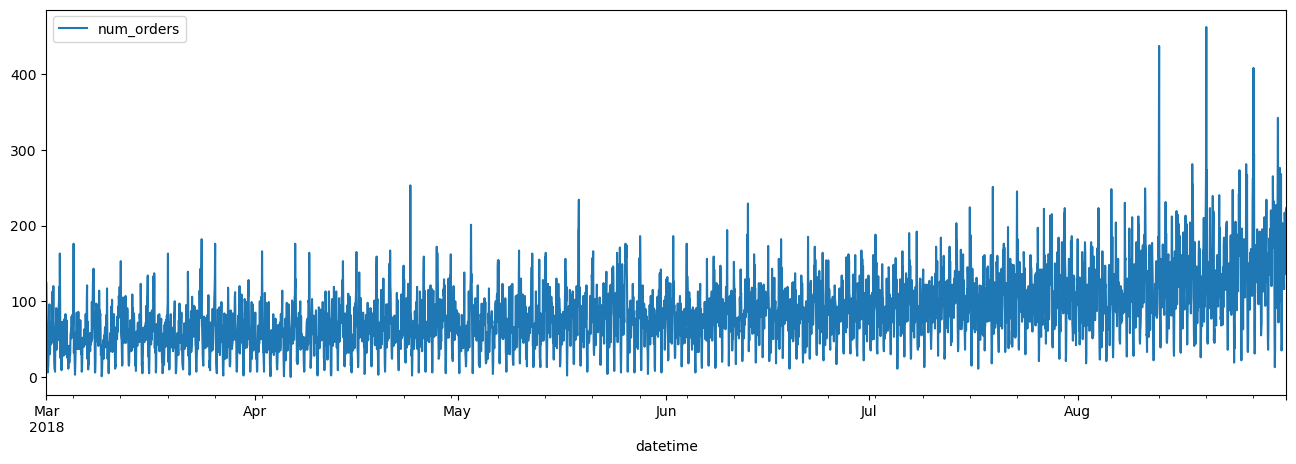

In [13]:
df.plot(figsize=(16,5))
plt.show()

We see that the average is clearly increasing. The standard deviation is the same. We will display it additionally on the graph

In [14]:
df['roll_mean'] = df['num_orders'].rolling(24, closed='left').mean()

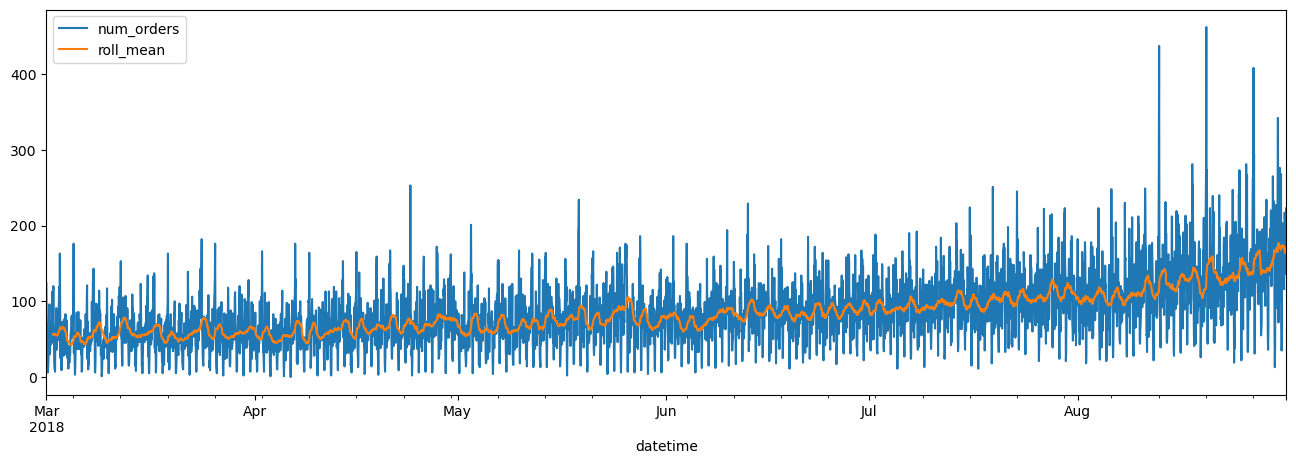

In [15]:
df.plot(figsize=(16,5))
plt.show()

In [16]:
df['roll_std'] = df['num_orders'].rolling(24, closed='left').std()

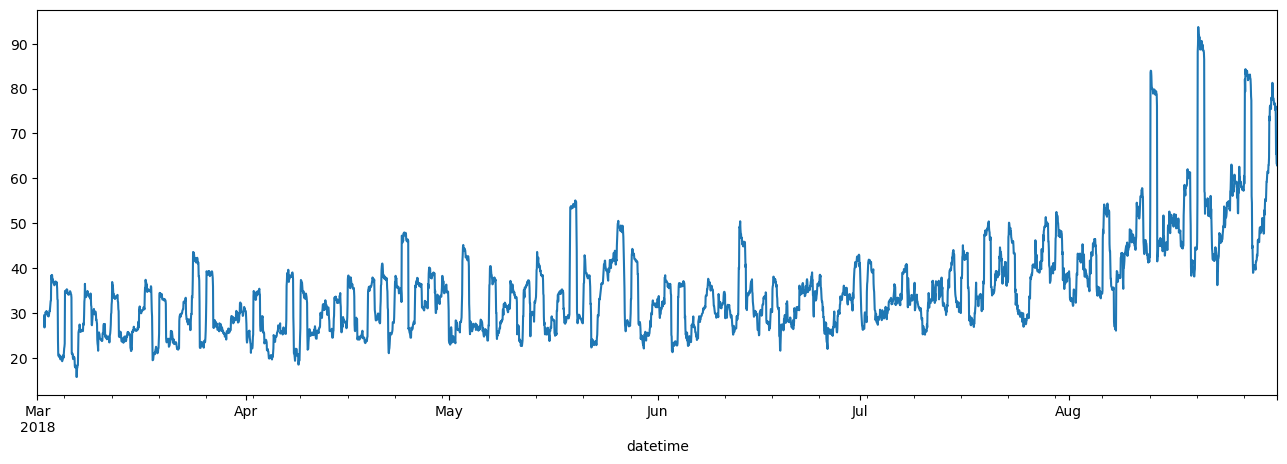

In [17]:
df['roll_std'].plot(figsize=(16,5))
plt.show()

### Let's make an assessment using the seasonal_decompose function

In [18]:
decomposed = seasonal_decompose(df['num_orders'])

#### Let's show the trend

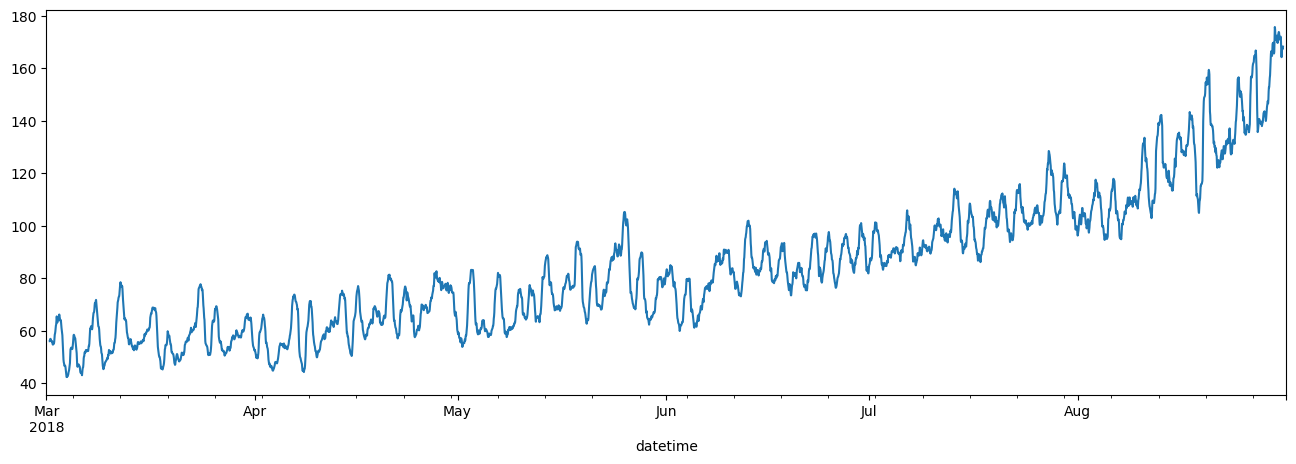

In [19]:
decomposed.trend.plot(figsize=(16,5))
plt.show()

According to this assessment, we also see that the trend is increasing

#### Let's output a seasonality chart

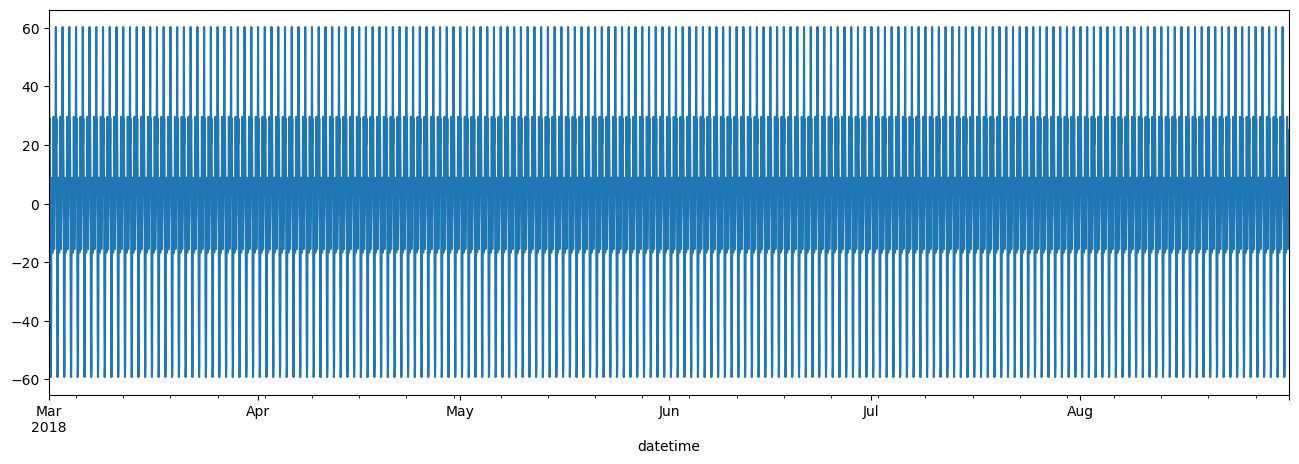

In [20]:
decomposed.seasonal.plot(figsize=(16,5))
plt.show()

It is not particularly clear what kind of seasonality we are observing. Let's limit ourselves to one month

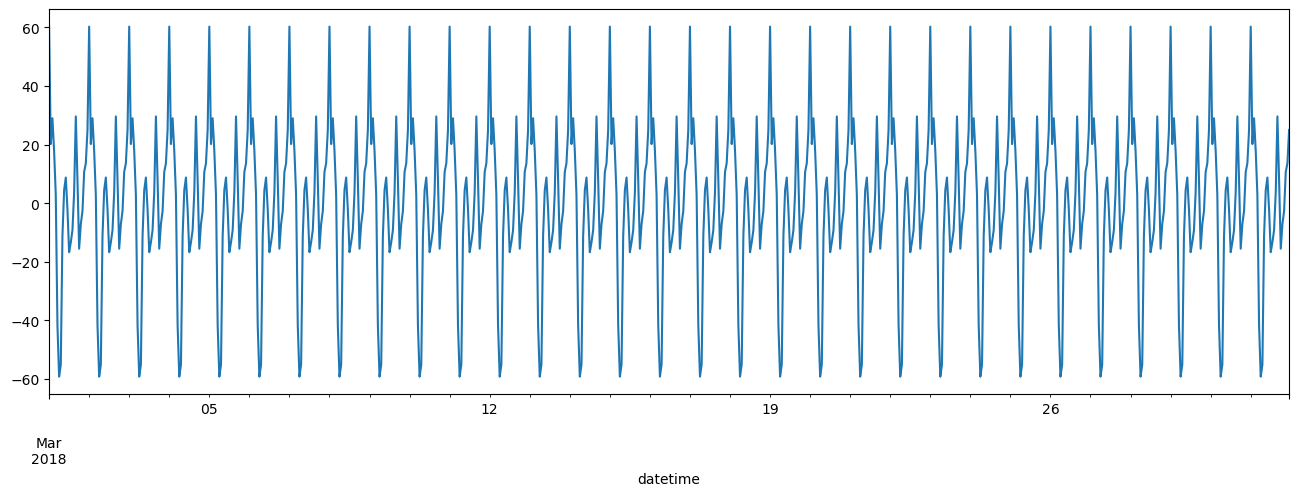

In [21]:
decomposed.seasonal['2018-03-01': '2018-03-31'].plot(figsize=(16,5))
plt.show()

There is also too much data. Let's limit ourselves to a week

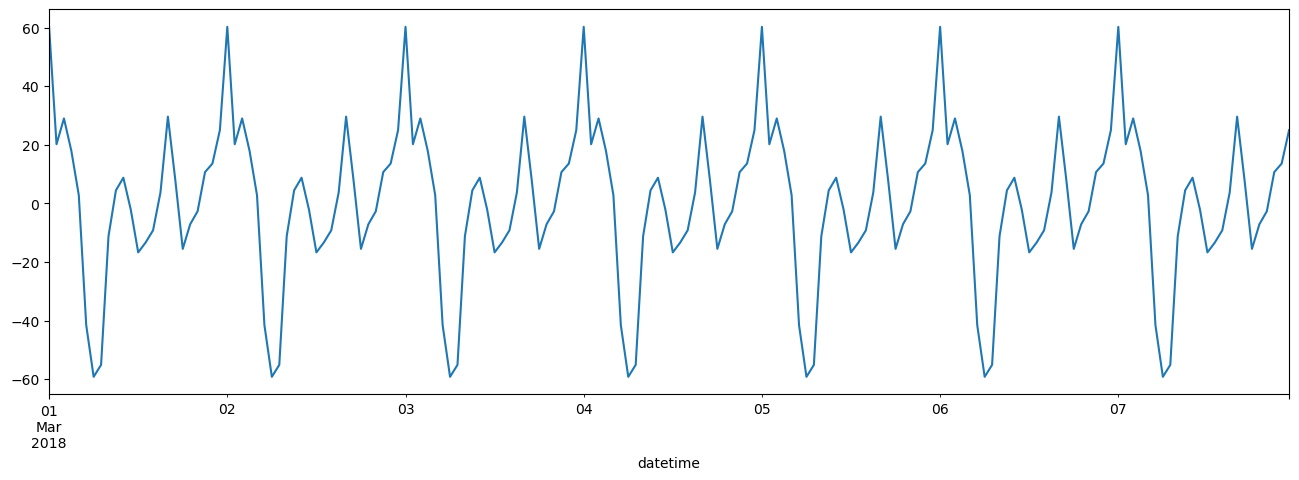

In [22]:
decomposed.seasonal['2018-03-01': '2018-03-07'].plot(figsize=(16,5))
plt.show()

There is clearly a daily seasonality here

#### Let's try to resample by day and check the seasonality

In [23]:
decomposed_day = seasonal_decompose(df['num_orders'].resample('1D').sum())

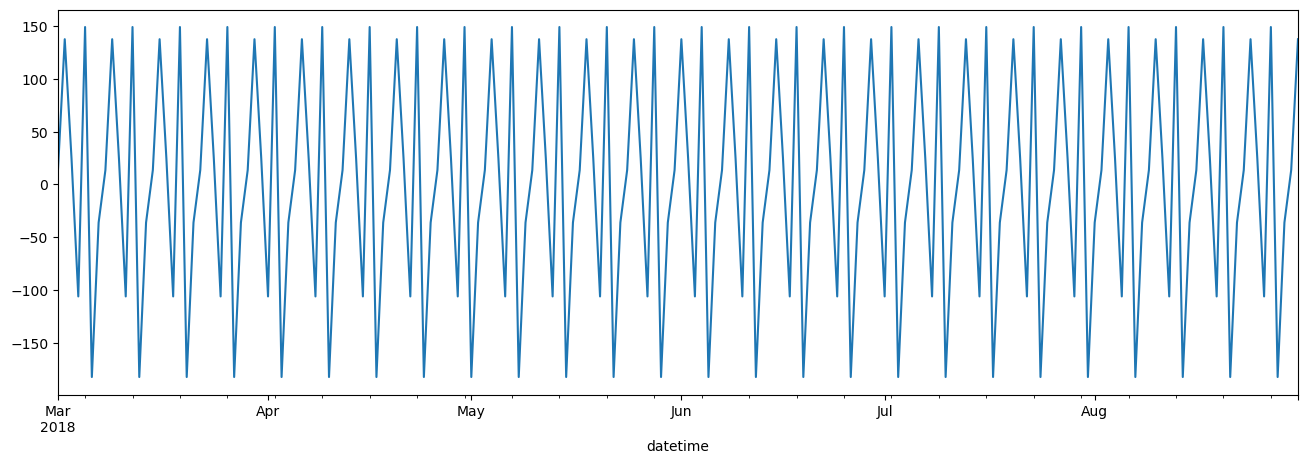

In [24]:
decomposed_day.seasonal.plot(figsize=(16,5))
plt.show()

When resampling by day, seasonality is also observed. Let's limit ourselves to a month

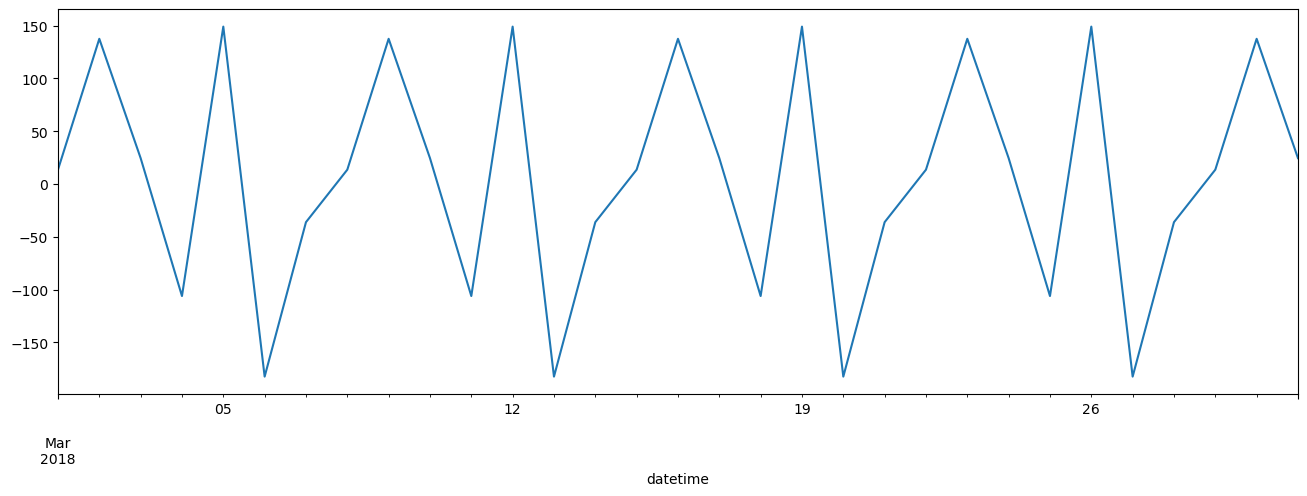

In [25]:
decomposed_day.seasonal['2018-03-01': '2018-03-31'].plot(figsize=(16,5))
plt.show()

There is a weekly seasonality here. Here I see that the pattern repeats 4 times

#### Let's output a graph of the residuals

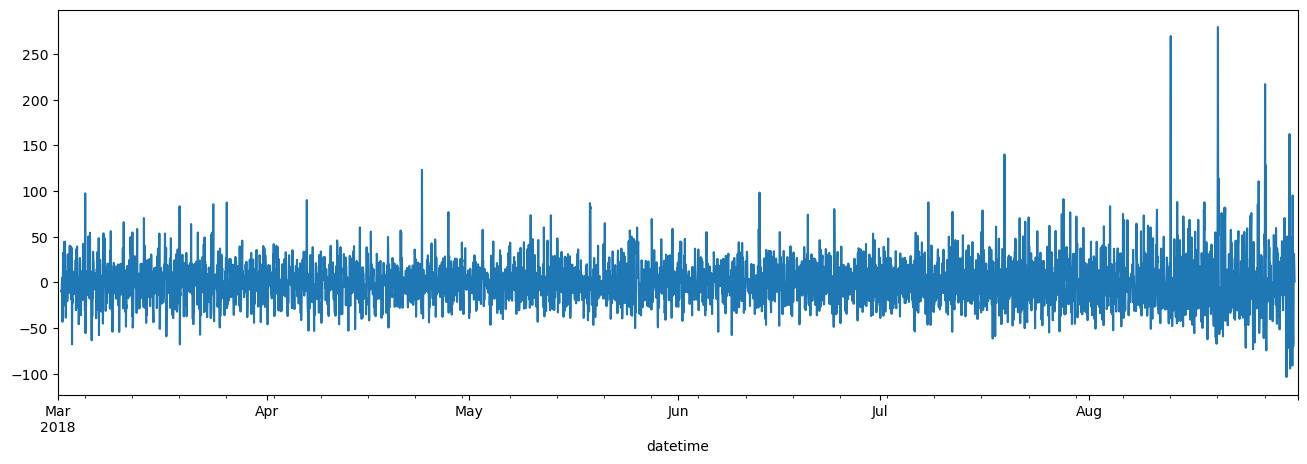

In [26]:
decomposed.resid.plot(figsize=(16,5))
plt.show()

At the end of this graph, we see that the leftovers are growing. And this period will fall into the test sample, which is probably not very good for the final metric, but it's okay in general

**Let's denote the null and alternative hypotheses**

H 0 : The time series is non-stationary. It has some time-dependent structure and does not have a constant variance over time.

H A : The time series is stationary.

We will set the significance level to 1 and 5%

Output the resulting p-value

In [27]:
p_value = adfuller(df['num_orders'])[1]
p_value

0.028940051402613857

In [28]:
def hypothesis_check(alpha):
    if p_value > alpha / 100:
        return f"Let's output the resulting p-value. It is impossible to reject the null hypothesis at the significance level of {alpha}%. The time series is non-stationary"
    else:
        return f"An alternative hypothesis has been confirmed at the significance level of {alpha}%. The time series is stationary"

In [29]:
hypothesis_check(5)

'An alternative hypothesis has been confirmed at the significance level of 5%. The time series is stationary'

In [30]:
hypothesis_check(1)

"Let's output the resulting p-value. It is impossible to reject the null hypothesis at the significance level of 1%. The time series is non-stationary"

It can be concluded that the time series is still non-stationary.

#### Creating additional features

##### Let's add a column in which we will display the number of requests at a given hour a day ago. I think it will be useful, since we have identified the daily seasonality

In [31]:
df['num_orders_day_shift'] = df['num_orders'].shift(24)

##### We will also add a column in which we will display the number of applications at a given hour a week ago

In [32]:
df['num_orders_week_shift'] = df['num_orders'].shift(24*7)

##### We will also add columns with the day of the week and the hour

In [33]:
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

In [34]:
df.head()

,num_orders,roll_mean,roll_std,num_orders_day_shift,num_orders_week_shift,day_of_week,hour
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,3,0
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,3,1
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,3,2
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,3,3
2018-03-01 04:00:00,43,NaN,NaN,NaN,NaN,3,4


### We will keep only the features for which the offset was used to calculate in order to prevent leakage of the target feature

In [35]:
df.columns

Index(['num_orders', 'roll_mean', 'roll_std', 'num_orders_day_shift',
       'num_orders_week_shift', 'day_of_week', 'hour'],
      dtype='object')

In [36]:
df = df.drop(['roll_mean', 'roll_std'], axis=1)

#### Let's divide the sample into a training and a test one

In [37]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Let's remove the missing values from the training sample

In [38]:
train = train.dropna()

Let's separate the features from the target

In [39]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

In [40]:
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

#### Apply OHE

In [41]:
cat = ['hour', 'day_of_week']

In [42]:
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

features_train_cat = pd.DataFrame(ohe.fit_transform(X_train[cat]), 
                                columns=ohe.get_feature_names(cat), 
                                index=X_train.index)

features_test_cat = pd.DataFrame(ohe.transform(X_test[cat]), 
                               columns=ohe.get_feature_names(cat), 
                               index=X_test.index)

X_train = X_train.drop(cat, axis=1).join(features_train_cat)
X_test = X_test.drop(cat, axis=1).join(features_test_cat)

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\gogad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Training

### Creating a linear regression model

**I decided not to use the conversion of features using standard scaller, as this is done so that the features are proportionate. And they are already proportionate**

Creating a model class

In [43]:
lr_model = LinearRegression()

Creating a TimeSeriesSplit object

In [44]:
tscv = TimeSeriesSplit(n_splits=5)

We calculate the RMSE for each fold

In [45]:
mse_scores = cross_val_score(lr_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
rmse_scores = np.sqrt(mse_scores)

Calculating RMSE

In [46]:
for i, rmse in enumerate(rmse_scores):
    print(f'Fold {i+1}: RMSE = {rmse}')

Fold 1: RMSE = 20.51867972994352
Fold 2: RMSE = 23.244189130474734
Fold 3: RMSE = 22.264292305854447
Fold 4: RMSE = 23.914312889356424
Fold 5: RMSE = 30.918027701994056


In [47]:
avg_rmse = np.mean(rmse_scores)
print(f'Average RMSE: {avg_rmse}')

Average RMSE: 24.171900351524634


The metric already turns out to be quite good. Significantly lower than the one required by the assignment. I tried to leave only one feature: either an offset for a day, or an offset for a week. The RMSE metric turned out a little worse

Let's train a linear regression model on the entire training sample

In [48]:
lr_model.fit(X_train, y_train)

LinearRegression()

### The catboost model

Creating a CatBoostRegressor model

In [49]:
catboost_model = CatBoostRegressor()

Setting parameters to find the best model

In [50]:
param_grid_cb = {
    'iterations': [500],
    'learning_rate': [0.01],
    'depth': [6, 8, 10, 12],
    'l2_leaf_reg': [1, 3, 5]
}

We are searching for the best catboost model

In [51]:
%%time
grid_search_result_cb = catboost_model.grid_search(param_grid_cb, 
                                                X=Pool(X_train, label=y_train),
                                                cv=tscv,
                                                plot='RMSE',
                                                partition_random_seed=42,
                                                verbose=False,
                                                search_by_train_test_split=True,
                                                refit=True,
                                                train_size=0.8)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 79.4519437	test: 114.1695922	best: 114.1695922 (0)	total: 152ms	remaining: 1m 15s
1:	learn: 78.7331816	test: 113.3101907	best: 113.3101907 (1)	total: 153ms	remaining: 38.2s
2:	learn: 78.0254009	test: 112.4789822	best: 112.4789822 (2)	total: 155ms	remaining: 25.6s
3:	learn: 77.3323974	test: 111.6058771	best: 111.6058771 (3)	total: 156ms	remaining: 19.3s
4:	learn: 76.6489631	test: 110.7593127	best: 110.7593127 (4)	total: 157ms	remaining: 15.6s
5:	learn: 75.9518185	test: 109.8519078	best: 109.8519078 (5)	total: 158ms	remaining: 13s
6:	learn: 75.3118685	test: 109.1859836	best: 109.1859836 (6)	total: 159ms	remaining: 11.2s
7:	learn: 74.6320302	test: 108.3187880	best: 108.3187880 (7)	total: 160ms	remaining: 9.83s
8:	learn: 73.9692155	test: 107.4767759	best: 107.4767759 (8)	total: 161ms	remaining: 8.78s
9:	learn: 73.3162553	test: 106.6291310	best: 106.6291310 (9)	total: 162ms	remaining: 7.94s
10:	learn: 72.6942018	test: 105.8656287	best: 105.8656287 (10)	total: 163ms	remaining: 7.25

145:	learn: 28.1278565	test: 47.3122229	best: 47.3122229 (145)	total: 783ms	remaining: 1.9s
146:	learn: 28.0034359	test: 47.1019612	best: 47.1019612 (146)	total: 784ms	remaining: 1.88s
147:	learn: 27.8815021	test: 46.9006081	best: 46.9006081 (147)	total: 785ms	remaining: 1.87s
148:	learn: 27.7650954	test: 46.7245663	best: 46.7245663 (148)	total: 786ms	remaining: 1.85s
149:	learn: 27.6451816	test: 46.5395172	best: 46.5395172 (149)	total: 788ms	remaining: 1.84s
150:	learn: 27.5313890	test: 46.3616397	best: 46.3616397 (150)	total: 789ms	remaining: 1.82s
151:	learn: 27.4159702	test: 46.1750063	best: 46.1750063 (151)	total: 790ms	remaining: 1.81s
152:	learn: 27.3037885	test: 46.0015396	best: 46.0015396 (152)	total: 791ms	remaining: 1.79s
153:	learn: 27.1933697	test: 45.8365003	best: 45.8365003 (153)	total: 792ms	remaining: 1.78s
154:	learn: 27.0821829	test: 45.6458147	best: 45.6458147 (154)	total: 793ms	remaining: 1.76s
155:	learn: 26.9749302	test: 45.4726328	best: 45.4726328 (155)	total: 7

257:	learn: 21.5495294	test: 35.2416287	best: 35.2416287 (257)	total: 981ms	remaining: 920ms
258:	learn: 21.5272155	test: 35.1924375	best: 35.1924375 (258)	total: 982ms	remaining: 914ms
259:	learn: 21.5060216	test: 35.1371767	best: 35.1371767 (259)	total: 983ms	remaining: 908ms
260:	learn: 21.4867838	test: 35.0918312	best: 35.0918312 (260)	total: 985ms	remaining: 902ms
261:	learn: 21.4677826	test: 35.0480876	best: 35.0480876 (261)	total: 986ms	remaining: 896ms
262:	learn: 21.4473489	test: 35.0043970	best: 35.0043970 (262)	total: 988ms	remaining: 890ms
263:	learn: 21.4283221	test: 34.9534012	best: 34.9534012 (263)	total: 989ms	remaining: 884ms
264:	learn: 21.4094051	test: 34.9060641	best: 34.9060641 (264)	total: 990ms	remaining: 878ms
265:	learn: 21.3906724	test: 34.8560952	best: 34.8560952 (265)	total: 992ms	remaining: 872ms
266:	learn: 21.3729113	test: 34.8082706	best: 34.8082706 (266)	total: 993ms	remaining: 866ms
267:	learn: 21.3550457	test: 34.7606415	best: 34.7606415 (267)	total: 

373:	learn: 20.3597612	test: 31.7749571	best: 31.7749571 (373)	total: 1.18s	remaining: 397ms
374:	learn: 20.3554915	test: 31.7592313	best: 31.7592313 (374)	total: 1.18s	remaining: 394ms
375:	learn: 20.3487083	test: 31.7418856	best: 31.7418856 (375)	total: 1.18s	remaining: 390ms
376:	learn: 20.3455742	test: 31.7273293	best: 31.7273293 (376)	total: 1.18s	remaining: 386ms
377:	learn: 20.3412929	test: 31.7129345	best: 31.7129345 (377)	total: 1.19s	remaining: 383ms
378:	learn: 20.3362844	test: 31.6979802	best: 31.6979802 (378)	total: 1.19s	remaining: 379ms
379:	learn: 20.3332835	test: 31.6823483	best: 31.6823483 (379)	total: 1.19s	remaining: 375ms
380:	learn: 20.3290491	test: 31.6677165	best: 31.6677165 (380)	total: 1.19s	remaining: 371ms
381:	learn: 20.3225831	test: 31.6504670	best: 31.6504670 (381)	total: 1.19s	remaining: 368ms
382:	learn: 20.3181903	test: 31.6376840	best: 31.6376840 (382)	total: 1.19s	remaining: 364ms
383:	learn: 20.3151750	test: 31.6250030	best: 31.6250030 (383)	total: 

485:	learn: 19.9930356	test: 30.7460885	best: 30.7460885 (485)	total: 1.38s	remaining: 39.7ms
486:	learn: 19.9913065	test: 30.7416307	best: 30.7416307 (486)	total: 1.38s	remaining: 36.8ms
487:	learn: 19.9878154	test: 30.7355146	best: 30.7355146 (487)	total: 1.38s	remaining: 33.9ms
488:	learn: 19.9853679	test: 30.7330141	best: 30.7330141 (488)	total: 1.38s	remaining: 31.1ms
489:	learn: 19.9822396	test: 30.7271790	best: 30.7271790 (489)	total: 1.38s	remaining: 28.2ms
490:	learn: 19.9792563	test: 30.7205954	best: 30.7205954 (490)	total: 1.38s	remaining: 25.4ms
491:	learn: 19.9752278	test: 30.7114844	best: 30.7114844 (491)	total: 1.39s	remaining: 22.5ms
492:	learn: 19.9734836	test: 30.7055137	best: 30.7055137 (492)	total: 1.39s	remaining: 19.7ms
493:	learn: 19.9708127	test: 30.6991824	best: 30.6991824 (493)	total: 1.39s	remaining: 16.9ms
494:	learn: 19.9683024	test: 30.6955558	best: 30.6955558 (494)	total: 1.39s	remaining: 14ms
495:	learn: 19.9654284	test: 30.6903926	best: 30.6903926 (495)

104:	learn: 35.1968160	test: 57.9193779	best: 57.9193779 (104)	total: 174ms	remaining: 653ms
105:	learn: 34.9802579	test: 57.6009399	best: 57.6009399 (105)	total: 175ms	remaining: 650ms
106:	learn: 34.7649233	test: 57.2973949	best: 57.2973949 (106)	total: 176ms	remaining: 647ms
107:	learn: 34.5501915	test: 56.9833808	best: 56.9833808 (107)	total: 177ms	remaining: 643ms
108:	learn: 34.3414128	test: 56.6742066	best: 56.6742066 (108)	total: 178ms	remaining: 640ms
109:	learn: 34.1380251	test: 56.3798173	best: 56.3798173 (109)	total: 180ms	remaining: 637ms
110:	learn: 33.9372875	test: 56.1076269	best: 56.1076269 (110)	total: 181ms	remaining: 634ms
111:	learn: 33.7373995	test: 55.8421438	best: 55.8421438 (111)	total: 182ms	remaining: 631ms
112:	learn: 33.5380929	test: 55.5601334	best: 55.5601334 (112)	total: 183ms	remaining: 628ms
113:	learn: 33.3427696	test: 55.3008155	best: 55.3008155 (113)	total: 185ms	remaining: 625ms
114:	learn: 33.1519730	test: 55.0431672	best: 55.0431672 (114)	total: 

236:	learn: 22.1833787	test: 37.0511723	best: 37.0511723 (236)	total: 372ms	remaining: 413ms
237:	learn: 22.1528594	test: 36.9836562	best: 36.9836562 (237)	total: 374ms	remaining: 412ms
238:	learn: 22.1242506	test: 36.9167012	best: 36.9167012 (238)	total: 375ms	remaining: 410ms
239:	learn: 22.0938140	test: 36.8436569	best: 36.8436569 (239)	total: 376ms	remaining: 408ms
240:	learn: 22.0638225	test: 36.7720882	best: 36.7720882 (240)	total: 378ms	remaining: 406ms
241:	learn: 22.0350930	test: 36.7027309	best: 36.7027309 (241)	total: 379ms	remaining: 404ms
242:	learn: 22.0085191	test: 36.6431325	best: 36.6431325 (242)	total: 380ms	remaining: 402ms
243:	learn: 21.9794415	test: 36.5734551	best: 36.5734551 (243)	total: 381ms	remaining: 400ms
244:	learn: 21.9521853	test: 36.5088286	best: 36.5088286 (244)	total: 383ms	remaining: 398ms
245:	learn: 21.9267949	test: 36.4546185	best: 36.4546185 (245)	total: 384ms	remaining: 396ms
246:	learn: 21.8993777	test: 36.3895682	best: 36.3895682 (246)	total: 

358:	learn: 20.4991300	test: 32.3158397	best: 32.3158397 (358)	total: 556ms	remaining: 218ms
359:	learn: 20.4938816	test: 32.2984918	best: 32.2984918 (359)	total: 557ms	remaining: 217ms
360:	learn: 20.4897499	test: 32.2839067	best: 32.2839067 (360)	total: 559ms	remaining: 215ms
361:	learn: 20.4852000	test: 32.2715720	best: 32.2715720 (361)	total: 560ms	remaining: 213ms
362:	learn: 20.4810535	test: 32.2550748	best: 32.2550748 (362)	total: 561ms	remaining: 212ms
363:	learn: 20.4761258	test: 32.2359864	best: 32.2359864 (363)	total: 563ms	remaining: 210ms
364:	learn: 20.4709193	test: 32.2156950	best: 32.2156950 (364)	total: 565ms	remaining: 209ms
365:	learn: 20.4658683	test: 32.1983037	best: 32.1983037 (365)	total: 567ms	remaining: 208ms
366:	learn: 20.4610077	test: 32.1828942	best: 32.1828942 (366)	total: 570ms	remaining: 206ms
367:	learn: 20.4562522	test: 32.1617784	best: 32.1617784 (367)	total: 572ms	remaining: 205ms
368:	learn: 20.4511603	test: 32.1433891	best: 32.1433891 (368)	total: 

486:	learn: 20.0775967	test: 30.9252228	best: 30.9252228 (486)	total: 765ms	remaining: 20.4ms
487:	learn: 20.0754694	test: 30.9196779	best: 30.9196779 (487)	total: 767ms	remaining: 18.9ms
488:	learn: 20.0733587	test: 30.9124039	best: 30.9124039 (488)	total: 768ms	remaining: 17.3ms
489:	learn: 20.0698390	test: 30.9057620	best: 30.9057620 (489)	total: 769ms	remaining: 15.7ms
490:	learn: 20.0663458	test: 30.9027429	best: 30.9027429 (490)	total: 771ms	remaining: 14.1ms
491:	learn: 20.0636455	test: 30.8975520	best: 30.8975520 (491)	total: 772ms	remaining: 12.6ms
492:	learn: 20.0618604	test: 30.8915433	best: 30.8915433 (492)	total: 773ms	remaining: 11ms
493:	learn: 20.0600679	test: 30.8863293	best: 30.8863293 (493)	total: 775ms	remaining: 9.41ms
494:	learn: 20.0577514	test: 30.8817495	best: 30.8817495 (494)	total: 776ms	remaining: 7.84ms
495:	learn: 20.0561077	test: 30.8748793	best: 30.8748793 (495)	total: 778ms	remaining: 6.27ms
496:	learn: 20.0531839	test: 30.8693658	best: 30.8693658 (496)

119:	learn: 32.4944169	test: 54.3496613	best: 54.3496613 (119)	total: 178ms	remaining: 562ms
120:	learn: 32.3162284	test: 54.0919568	best: 54.0919568 (120)	total: 179ms	remaining: 561ms
121:	learn: 32.1438865	test: 53.8582581	best: 53.8582581 (121)	total: 180ms	remaining: 558ms
122:	learn: 31.9716487	test: 53.6039784	best: 53.6039784 (122)	total: 181ms	remaining: 556ms
123:	learn: 31.7978012	test: 53.3418808	best: 53.3418808 (123)	total: 183ms	remaining: 554ms
124:	learn: 31.6271637	test: 53.0909033	best: 53.0909033 (124)	total: 184ms	remaining: 552ms
125:	learn: 31.4698024	test: 52.8722964	best: 52.8722964 (125)	total: 185ms	remaining: 550ms
126:	learn: 31.3065659	test: 52.6463385	best: 52.6463385 (126)	total: 187ms	remaining: 549ms
127:	learn: 31.1386917	test: 52.3812989	best: 52.3812989 (127)	total: 188ms	remaining: 547ms
128:	learn: 30.9779502	test: 52.1352754	best: 52.1352754 (128)	total: 190ms	remaining: 545ms
129:	learn: 30.8218783	test: 51.8966999	best: 51.8966999 (129)	total: 

250:	learn: 21.9119953	test: 36.5254218	best: 36.5254218 (250)	total: 375ms	remaining: 372ms
251:	learn: 21.8872549	test: 36.4594421	best: 36.4594421 (251)	total: 376ms	remaining: 370ms
252:	learn: 21.8641670	test: 36.4086957	best: 36.4086957 (252)	total: 377ms	remaining: 368ms
253:	learn: 21.8399641	test: 36.3538913	best: 36.3538913 (253)	total: 379ms	remaining: 367ms
254:	learn: 21.8151052	test: 36.2882818	best: 36.2882818 (254)	total: 380ms	remaining: 365ms
255:	learn: 21.7913055	test: 36.2297257	best: 36.2297257 (255)	total: 382ms	remaining: 364ms
256:	learn: 21.7670601	test: 36.1726951	best: 36.1726951 (256)	total: 383ms	remaining: 362ms
257:	learn: 21.7442746	test: 36.1144176	best: 36.1144176 (257)	total: 385ms	remaining: 361ms
258:	learn: 21.7208287	test: 36.0615867	best: 36.0615867 (258)	total: 386ms	remaining: 359ms
259:	learn: 21.6994276	test: 36.0074406	best: 36.0074406 (259)	total: 387ms	remaining: 358ms
260:	learn: 21.6787550	test: 35.9585215	best: 35.9585215 (260)	total: 

384:	learn: 20.4464392	test: 32.1960970	best: 32.1960970 (384)	total: 572ms	remaining: 171ms
385:	learn: 20.4426894	test: 32.1799970	best: 32.1799970 (385)	total: 574ms	remaining: 170ms
386:	learn: 20.4383855	test: 32.1615860	best: 32.1615860 (386)	total: 575ms	remaining: 168ms
387:	learn: 20.4355912	test: 32.1476715	best: 32.1476715 (387)	total: 577ms	remaining: 166ms
388:	learn: 20.4321345	test: 32.1338105	best: 32.1338105 (388)	total: 578ms	remaining: 165ms
389:	learn: 20.4284029	test: 32.1171835	best: 32.1171835 (389)	total: 579ms	remaining: 163ms
390:	learn: 20.4243674	test: 32.1014881	best: 32.1014881 (390)	total: 581ms	remaining: 162ms
391:	learn: 20.4201803	test: 32.0830246	best: 32.0830246 (391)	total: 582ms	remaining: 160ms
392:	learn: 20.4143197	test: 32.0649643	best: 32.0649643 (392)	total: 583ms	remaining: 159ms
393:	learn: 20.4096872	test: 32.0510900	best: 32.0510900 (393)	total: 584ms	remaining: 157ms
394:	learn: 20.4049681	test: 32.0377647	best: 32.0377647 (394)	total: 

13:	learn: 70.6928774	test: 103.3371979	best: 103.3371979 (13)	total: 43ms	remaining: 1.49s
14:	learn: 70.0635379	test: 102.5178736	best: 102.5178736 (14)	total: 45.4ms	remaining: 1.47s
15:	learn: 69.4441567	test: 101.7635885	best: 101.7635885 (15)	total: 46.8ms	remaining: 1.42s
16:	learn: 68.8219819	test: 100.9700173	best: 100.9700173 (16)	total: 49.2ms	remaining: 1.4s
17:	learn: 68.2122174	test: 100.1817766	best: 100.1817766 (17)	total: 51.5ms	remaining: 1.38s
18:	learn: 67.6187972	test: 99.4810717	best: 99.4810717 (18)	total: 54.1ms	remaining: 1.37s
19:	learn: 67.0327482	test: 98.7361577	best: 98.7361577 (19)	total: 55ms	remaining: 1.32s
20:	learn: 66.4450924	test: 98.0111024	best: 98.0111024 (20)	total: 58ms	remaining: 1.32s
21:	learn: 65.8638796	test: 97.3042919	best: 97.3042919 (21)	total: 60.7ms	remaining: 1.32s
22:	learn: 65.2905264	test: 96.5498232	best: 96.5498232 (22)	total: 63.6ms	remaining: 1.32s
23:	learn: 64.7220430	test: 95.8042724	best: 95.8042724 (23)	total: 66.5ms	re

151:	learn: 27.2443975	test: 46.0906095	best: 46.0906095 (151)	total: 448ms	remaining: 1.02s
152:	learn: 27.1320833	test: 45.9198138	best: 45.9198138 (152)	total: 451ms	remaining: 1.02s
153:	learn: 27.0173013	test: 45.7301069	best: 45.7301069 (153)	total: 454ms	remaining: 1.02s
154:	learn: 26.9088859	test: 45.5550273	best: 45.5550273 (154)	total: 456ms	remaining: 1.01s
155:	learn: 26.7992826	test: 45.3896863	best: 45.3896863 (155)	total: 458ms	remaining: 1.01s
156:	learn: 26.6947533	test: 45.2277166	best: 45.2277166 (156)	total: 459ms	remaining: 1s
157:	learn: 26.5884000	test: 45.0557835	best: 45.0557835 (157)	total: 462ms	remaining: 1s
158:	learn: 26.4827392	test: 44.8847917	best: 44.8847917 (158)	total: 465ms	remaining: 998ms
159:	learn: 26.3828112	test: 44.7252019	best: 44.7252019 (159)	total: 467ms	remaining: 992ms
160:	learn: 26.2798371	test: 44.5567356	best: 44.5567356 (160)	total: 470ms	remaining: 990ms
161:	learn: 26.1790408	test: 44.3950176	best: 44.3950176 (161)	total: 473ms	

300:	learn: 20.5843552	test: 33.5365020	best: 33.5365020 (300)	total: 851ms	remaining: 562ms
301:	learn: 20.5732455	test: 33.5059479	best: 33.5059479 (301)	total: 853ms	remaining: 559ms
302:	learn: 20.5601323	test: 33.4759747	best: 33.4759747 (302)	total: 856ms	remaining: 557ms
303:	learn: 20.5522943	test: 33.4546150	best: 33.4546150 (303)	total: 857ms	remaining: 553ms
304:	learn: 20.5419422	test: 33.4265899	best: 33.4265899 (304)	total: 860ms	remaining: 550ms
305:	learn: 20.5297906	test: 33.3944142	best: 33.3944142 (305)	total: 862ms	remaining: 547ms
306:	learn: 20.5207132	test: 33.3662235	best: 33.3662235 (306)	total: 863ms	remaining: 543ms
307:	learn: 20.5104379	test: 33.3381799	best: 33.3381799 (307)	total: 866ms	remaining: 540ms
308:	learn: 20.5011114	test: 33.3058963	best: 33.3058963 (308)	total: 868ms	remaining: 537ms
309:	learn: 20.4883707	test: 33.2709439	best: 33.2709439 (309)	total: 870ms	remaining: 533ms
310:	learn: 20.4800260	test: 33.2420938	best: 33.2420938 (310)	total: 

448:	learn: 19.6301686	test: 31.0511880	best: 31.0511880 (448)	total: 1.25s	remaining: 142ms
449:	learn: 19.6270226	test: 31.0468645	best: 31.0468645 (449)	total: 1.25s	remaining: 139ms
450:	learn: 19.6222726	test: 31.0380947	best: 31.0380947 (450)	total: 1.26s	remaining: 137ms
451:	learn: 19.6203275	test: 31.0325252	best: 31.0325252 (451)	total: 1.26s	remaining: 134ms
452:	learn: 19.6174232	test: 31.0270443	best: 31.0270443 (452)	total: 1.26s	remaining: 131ms
453:	learn: 19.6116238	test: 31.0173663	best: 31.0173663 (453)	total: 1.26s	remaining: 128ms
454:	learn: 19.6079236	test: 31.0109005	best: 31.0109005 (454)	total: 1.27s	remaining: 125ms
455:	learn: 19.6061656	test: 31.0056836	best: 31.0056836 (455)	total: 1.27s	remaining: 122ms
456:	learn: 19.6037257	test: 31.0010781	best: 31.0010781 (456)	total: 1.27s	remaining: 120ms
457:	learn: 19.5988515	test: 30.9965750	best: 30.9965750 (457)	total: 1.27s	remaining: 117ms
458:	learn: 19.5963600	test: 30.9891693	best: 30.9891693 (458)	total: 

93:	learn: 37.8722498	test: 61.6191542	best: 61.6191542 (93)	total: 265ms	remaining: 1.15s
94:	learn: 37.6246500	test: 61.3052442	best: 61.3052442 (94)	total: 266ms	remaining: 1.14s
95:	learn: 37.3715858	test: 60.9638317	best: 60.9638317 (95)	total: 269ms	remaining: 1.13s
96:	learn: 37.1238604	test: 60.6256351	best: 60.6256351 (96)	total: 272ms	remaining: 1.13s
97:	learn: 36.8811606	test: 60.2995610	best: 60.2995610 (97)	total: 275ms	remaining: 1.13s
98:	learn: 36.6435606	test: 59.9644746	best: 59.9644746 (98)	total: 277ms	remaining: 1.12s
99:	learn: 36.4084799	test: 59.6254936	best: 59.6254936 (99)	total: 280ms	remaining: 1.12s
100:	learn: 36.1745066	test: 59.2934962	best: 59.2934962 (100)	total: 283ms	remaining: 1.12s
101:	learn: 35.9451783	test: 58.9922336	best: 58.9922336 (101)	total: 286ms	remaining: 1.11s
102:	learn: 35.7135811	test: 58.6792309	best: 58.6792309 (102)	total: 289ms	remaining: 1.11s
103:	learn: 35.4899070	test: 58.3805993	best: 58.3805993 (103)	total: 292ms	remainin

242:	learn: 21.8164208	test: 36.7656313	best: 36.7656313 (242)	total: 665ms	remaining: 703ms
243:	learn: 21.7879841	test: 36.7041951	best: 36.7041951 (243)	total: 668ms	remaining: 700ms
244:	learn: 21.7585385	test: 36.6403176	best: 36.6403176 (244)	total: 670ms	remaining: 697ms
245:	learn: 21.7302999	test: 36.5732378	best: 36.5732378 (245)	total: 673ms	remaining: 694ms
246:	learn: 21.7028859	test: 36.5140936	best: 36.5140936 (246)	total: 675ms	remaining: 692ms
247:	learn: 21.6757593	test: 36.4566084	best: 36.4566084 (247)	total: 678ms	remaining: 689ms
248:	learn: 21.6487853	test: 36.3948859	best: 36.3948859 (248)	total: 681ms	remaining: 687ms
249:	learn: 21.6238825	test: 36.3349446	best: 36.3349446 (249)	total: 684ms	remaining: 684ms
250:	learn: 21.5972936	test: 36.2715188	best: 36.2715188 (250)	total: 688ms	remaining: 683ms
251:	learn: 21.5727062	test: 36.2194021	best: 36.2194021 (251)	total: 691ms	remaining: 680ms
252:	learn: 21.5471092	test: 36.1587630	best: 36.1587630 (252)	total: 

383:	learn: 20.0443708	test: 32.0039595	best: 32.0039595 (383)	total: 1.06s	remaining: 321ms
384:	learn: 20.0388764	test: 31.9868153	best: 31.9868153 (384)	total: 1.06s	remaining: 318ms
385:	learn: 20.0335628	test: 31.9735530	best: 31.9735530 (385)	total: 1.07s	remaining: 315ms
386:	learn: 20.0265845	test: 31.9587572	best: 31.9587572 (386)	total: 1.07s	remaining: 313ms
387:	learn: 20.0225461	test: 31.9427118	best: 31.9427118 (387)	total: 1.07s	remaining: 310ms
388:	learn: 20.0184467	test: 31.9290617	best: 31.9290617 (388)	total: 1.08s	remaining: 307ms
389:	learn: 20.0142538	test: 31.9118985	best: 31.9118985 (389)	total: 1.08s	remaining: 305ms
390:	learn: 20.0121721	test: 31.9028209	best: 31.9028209 (390)	total: 1.08s	remaining: 302ms
391:	learn: 20.0068283	test: 31.8831120	best: 31.8831120 (391)	total: 1.09s	remaining: 299ms
392:	learn: 20.0035228	test: 31.8717245	best: 31.8717245 (392)	total: 1.09s	remaining: 297ms
393:	learn: 19.9992189	test: 31.8571924	best: 31.8571924 (393)	total: 

13:	learn: 70.9482604	test: 103.8360758	best: 103.8360758 (13)	total: 45ms	remaining: 1.56s
14:	learn: 70.3454938	test: 103.0775534	best: 103.0775534 (14)	total: 48ms	remaining: 1.55s
15:	learn: 69.7357253	test: 102.3361116	best: 102.3361116 (15)	total: 49.8ms	remaining: 1.51s
16:	learn: 69.1224332	test: 101.5529845	best: 101.5529845 (16)	total: 52.9ms	remaining: 1.5s
17:	learn: 68.5357543	test: 100.7969226	best: 100.7969226 (17)	total: 56ms	remaining: 1.5s
18:	learn: 67.9580883	test: 100.1397525	best: 100.1397525 (18)	total: 58.9ms	remaining: 1.49s
19:	learn: 67.3741430	test: 99.3993414	best: 99.3993414 (19)	total: 59.7ms	remaining: 1.43s
20:	learn: 66.8025013	test: 98.6977300	best: 98.6977300 (20)	total: 62.3ms	remaining: 1.42s
21:	learn: 66.2303325	test: 98.0089762	best: 98.0089762 (21)	total: 65.2ms	remaining: 1.42s
22:	learn: 65.6784623	test: 97.2931003	best: 97.2931003 (22)	total: 68ms	remaining: 1.41s
23:	learn: 65.1369144	test: 96.6008349	best: 96.6008349 (23)	total: 70.7ms	rem

163:	learn: 26.5675804	test: 45.8041685	best: 45.8041685 (163)	total: 463ms	remaining: 948ms
164:	learn: 26.4693385	test: 45.6466869	best: 45.6466869 (164)	total: 466ms	remaining: 946ms
165:	learn: 26.3715277	test: 45.4788029	best: 45.4788029 (165)	total: 469ms	remaining: 943ms
166:	learn: 26.2723552	test: 45.3130178	best: 45.3130178 (166)	total: 472ms	remaining: 940ms
167:	learn: 26.1787602	test: 45.1697941	best: 45.1697941 (167)	total: 474ms	remaining: 938ms
168:	learn: 26.0875124	test: 45.0364017	best: 45.0364017 (168)	total: 477ms	remaining: 935ms
169:	learn: 25.9938324	test: 44.8743671	best: 44.8743671 (169)	total: 480ms	remaining: 932ms
170:	learn: 25.9051258	test: 44.7482779	best: 44.7482779 (170)	total: 483ms	remaining: 929ms
171:	learn: 25.8199196	test: 44.6161088	best: 44.6161088 (171)	total: 486ms	remaining: 926ms
172:	learn: 25.7324907	test: 44.4645832	best: 44.4645832 (172)	total: 489ms	remaining: 924ms
173:	learn: 25.6440984	test: 44.3153505	best: 44.3153505 (173)	total: 

300:	learn: 20.8243369	test: 34.4865961	best: 34.4865961 (300)	total: 864ms	remaining: 571ms
301:	learn: 20.8113583	test: 34.4502390	best: 34.4502390 (301)	total: 867ms	remaining: 568ms
302:	learn: 20.7994456	test: 34.4222201	best: 34.4222201 (302)	total: 870ms	remaining: 565ms
303:	learn: 20.7860524	test: 34.3814976	best: 34.3814976 (303)	total: 872ms	remaining: 562ms
304:	learn: 20.7738754	test: 34.3464743	best: 34.3464743 (304)	total: 875ms	remaining: 559ms
305:	learn: 20.7620478	test: 34.3119783	best: 34.3119783 (305)	total: 877ms	remaining: 556ms
306:	learn: 20.7476548	test: 34.2721025	best: 34.2721025 (306)	total: 880ms	remaining: 553ms
307:	learn: 20.7365548	test: 34.2323068	best: 34.2323068 (307)	total: 881ms	remaining: 549ms
308:	learn: 20.7250614	test: 34.1958598	best: 34.1958598 (308)	total: 883ms	remaining: 546ms
309:	learn: 20.7133990	test: 34.1608219	best: 34.1608219 (309)	total: 886ms	remaining: 543ms
310:	learn: 20.7009747	test: 34.1268888	best: 34.1268888 (310)	total: 

447:	learn: 19.8868884	test: 31.5413186	best: 31.5413186 (447)	total: 1.27s	remaining: 147ms
448:	learn: 19.8848024	test: 31.5347808	best: 31.5347808 (448)	total: 1.27s	remaining: 144ms
449:	learn: 19.8800948	test: 31.5243767	best: 31.5243767 (449)	total: 1.27s	remaining: 141ms
450:	learn: 19.8769584	test: 31.5169631	best: 31.5169631 (450)	total: 1.27s	remaining: 139ms
451:	learn: 19.8746773	test: 31.5090574	best: 31.5090574 (451)	total: 1.28s	remaining: 136ms
452:	learn: 19.8715840	test: 31.5007783	best: 31.5007783 (452)	total: 1.28s	remaining: 133ms
453:	learn: 19.8676914	test: 31.4926822	best: 31.4926822 (453)	total: 1.28s	remaining: 130ms
454:	learn: 19.8643248	test: 31.4845513	best: 31.4845513 (454)	total: 1.28s	remaining: 127ms
455:	learn: 19.8598491	test: 31.4754115	best: 31.4754115 (455)	total: 1.29s	remaining: 124ms
456:	learn: 19.8564934	test: 31.4679877	best: 31.4679877 (456)	total: 1.29s	remaining: 121ms
457:	learn: 19.8533168	test: 31.4584585	best: 31.4584585 (457)	total: 

53:	learn: 50.3900717	test: 78.0496558	best: 78.0496558 (53)	total: 491ms	remaining: 4.05s
54:	learn: 49.9925293	test: 77.5189600	best: 77.5189600 (54)	total: 500ms	remaining: 4.05s
55:	learn: 49.5949461	test: 76.9797073	best: 76.9797073 (55)	total: 502ms	remaining: 3.98s
56:	learn: 49.2020178	test: 76.4746873	best: 76.4746873 (56)	total: 513ms	remaining: 3.99s
57:	learn: 48.8072871	test: 75.9633213	best: 75.9633213 (57)	total: 522ms	remaining: 3.98s
58:	learn: 48.4186626	test: 75.4560041	best: 75.4560041 (58)	total: 529ms	remaining: 3.96s
59:	learn: 48.0337483	test: 74.9606328	best: 74.9606328 (59)	total: 542ms	remaining: 3.97s
60:	learn: 47.6575031	test: 74.4722846	best: 74.4722846 (60)	total: 553ms	remaining: 3.98s
61:	learn: 47.2838257	test: 73.9759690	best: 73.9759690 (61)	total: 564ms	remaining: 3.99s
62:	learn: 46.9138319	test: 73.4905317	best: 73.4905317 (62)	total: 578ms	remaining: 4.01s
63:	learn: 46.5491492	test: 73.0325262	best: 73.0325262 (63)	total: 591ms	remaining: 4.03s

149:	learn: 27.3363320	test: 46.8070796	best: 46.8070796 (149)	total: 1.32s	remaining: 3.09s
150:	learn: 27.2151628	test: 46.6151542	best: 46.6151542 (150)	total: 1.33s	remaining: 3.08s
151:	learn: 27.0967130	test: 46.4253408	best: 46.4253408 (151)	total: 1.34s	remaining: 3.07s
152:	learn: 26.9770507	test: 46.2373945	best: 46.2373945 (152)	total: 1.35s	remaining: 3.07s
153:	learn: 26.8640920	test: 46.0700835	best: 46.0700835 (153)	total: 1.36s	remaining: 3.06s
154:	learn: 26.7527017	test: 45.9050906	best: 45.9050906 (154)	total: 1.37s	remaining: 3.05s
155:	learn: 26.6451239	test: 45.7384530	best: 45.7384530 (155)	total: 1.38s	remaining: 3.04s
156:	learn: 26.5388370	test: 45.5793871	best: 45.5793871 (156)	total: 1.39s	remaining: 3.03s
157:	learn: 26.4332947	test: 45.4031391	best: 45.4031391 (157)	total: 1.39s	remaining: 3.01s
158:	learn: 26.3281329	test: 45.2303325	best: 45.2303325 (158)	total: 1.39s	remaining: 2.99s
159:	learn: 26.2211409	test: 45.0600606	best: 45.0600606 (159)	total: 

239:	learn: 21.4019600	test: 36.5836818	best: 36.5836818 (239)	total: 2.15s	remaining: 2.33s
240:	learn: 21.3734129	test: 36.5167394	best: 36.5167394 (240)	total: 2.16s	remaining: 2.32s
241:	learn: 21.3438370	test: 36.4516415	best: 36.4516415 (241)	total: 2.17s	remaining: 2.31s
242:	learn: 21.3151378	test: 36.3861354	best: 36.3861354 (242)	total: 2.18s	remaining: 2.31s
243:	learn: 21.2852330	test: 36.3203644	best: 36.3203644 (243)	total: 2.19s	remaining: 2.3s
244:	learn: 21.2566627	test: 36.2564642	best: 36.2564642 (244)	total: 2.2s	remaining: 2.29s
245:	learn: 21.2294244	test: 36.1999109	best: 36.1999109 (245)	total: 2.21s	remaining: 2.28s
246:	learn: 21.2015241	test: 36.1389093	best: 36.1389093 (246)	total: 2.22s	remaining: 2.27s
247:	learn: 21.1740299	test: 36.0769570	best: 36.0769570 (247)	total: 2.23s	remaining: 2.27s
248:	learn: 21.1450319	test: 36.0179714	best: 36.0179714 (248)	total: 2.24s	remaining: 2.26s
249:	learn: 21.1202503	test: 35.9576552	best: 35.9576552 (249)	total: 2.

333:	learn: 19.7938460	test: 32.8354281	best: 32.8354281 (333)	total: 3s	remaining: 1.49s
334:	learn: 19.7853429	test: 32.8133345	best: 32.8133345 (334)	total: 3.01s	remaining: 1.48s
335:	learn: 19.7771157	test: 32.7884198	best: 32.7884198 (335)	total: 3.02s	remaining: 1.48s
336:	learn: 19.7693519	test: 32.7650500	best: 32.7650500 (336)	total: 3.03s	remaining: 1.47s
337:	learn: 19.7603034	test: 32.7377613	best: 32.7377613 (337)	total: 3.04s	remaining: 1.46s
338:	learn: 19.7497678	test: 32.7149857	best: 32.7149857 (338)	total: 3.06s	remaining: 1.45s
339:	learn: 19.7429563	test: 32.6899992	best: 32.6899992 (339)	total: 3.07s	remaining: 1.44s
340:	learn: 19.7363381	test: 32.6708362	best: 32.6708362 (340)	total: 3.08s	remaining: 1.44s
341:	learn: 19.7301599	test: 32.6506340	best: 32.6506340 (341)	total: 3.09s	remaining: 1.43s
342:	learn: 19.7218617	test: 32.6263828	best: 32.6263828 (342)	total: 3.1s	remaining: 1.42s
343:	learn: 19.7124410	test: 32.6006585	best: 32.6006585 (343)	total: 3.11

442:	learn: 19.0563986	test: 31.3179857	best: 31.3179857 (442)	total: 4.07s	remaining: 523ms
443:	learn: 19.0529105	test: 31.3101770	best: 31.3101770 (443)	total: 4.08s	remaining: 514ms
444:	learn: 19.0473551	test: 31.3060310	best: 31.3060310 (444)	total: 4.09s	remaining: 505ms
445:	learn: 19.0458052	test: 31.2994199	best: 31.2994199 (445)	total: 4.09s	remaining: 496ms
446:	learn: 19.0391155	test: 31.2924237	best: 31.2924237 (446)	total: 4.11s	remaining: 487ms
447:	learn: 19.0325319	test: 31.2852321	best: 31.2852321 (447)	total: 4.12s	remaining: 478ms
448:	learn: 19.0290694	test: 31.2785803	best: 31.2785803 (448)	total: 4.13s	remaining: 469ms
449:	learn: 19.0239941	test: 31.2715427	best: 31.2715427 (449)	total: 4.14s	remaining: 460ms
450:	learn: 19.0174707	test: 31.2617170	best: 31.2617170 (450)	total: 4.15s	remaining: 451ms
451:	learn: 19.0138733	test: 31.2568118	best: 31.2568118 (451)	total: 4.16s	remaining: 441ms
452:	learn: 19.0090427	test: 31.2482613	best: 31.2482613 (452)	total: 

56:	learn: 49.7210618	test: 77.4854645	best: 77.4854645 (56)	total: 482ms	remaining: 3.75s
57:	learn: 49.3301624	test: 76.9715193	best: 76.9715193 (57)	total: 487ms	remaining: 3.71s
58:	learn: 48.9431905	test: 76.4735690	best: 76.4735690 (58)	total: 493ms	remaining: 3.69s
59:	learn: 48.5597699	test: 75.9528418	best: 75.9528418 (59)	total: 504ms	remaining: 3.69s
60:	learn: 48.1823751	test: 75.4686247	best: 75.4686247 (60)	total: 515ms	remaining: 3.71s
61:	learn: 47.8104048	test: 74.9781574	best: 74.9781574 (61)	total: 524ms	remaining: 3.7s
62:	learn: 47.4478168	test: 74.5090751	best: 74.5090751 (62)	total: 534ms	remaining: 3.71s
63:	learn: 47.0820590	test: 74.0425025	best: 74.0425025 (63)	total: 544ms	remaining: 3.7s
64:	learn: 46.7263775	test: 73.5721095	best: 73.5721095 (64)	total: 553ms	remaining: 3.7s
65:	learn: 46.3780141	test: 73.1237108	best: 73.1237108 (65)	total: 566ms	remaining: 3.72s
66:	learn: 46.0345938	test: 72.6798552	best: 72.6798552 (66)	total: 578ms	remaining: 3.73s
67

153:	learn: 27.3457120	test: 47.2014974	best: 47.2014974 (153)	total: 1.31s	remaining: 2.95s
154:	learn: 27.2304209	test: 47.0280145	best: 47.0280145 (154)	total: 1.32s	remaining: 2.94s
155:	learn: 27.1196305	test: 46.8604259	best: 46.8604259 (155)	total: 1.33s	remaining: 2.94s
156:	learn: 27.0119734	test: 46.7081607	best: 46.7081607 (156)	total: 1.34s	remaining: 2.93s
157:	learn: 26.9029630	test: 46.5294409	best: 46.5294409 (157)	total: 1.34s	remaining: 2.9s
158:	learn: 26.7950020	test: 46.3683342	best: 46.3683342 (158)	total: 1.34s	remaining: 2.88s
159:	learn: 26.6879595	test: 46.2040752	best: 46.2040752 (159)	total: 1.36s	remaining: 2.88s
160:	learn: 26.5827267	test: 46.0287858	best: 46.0287858 (160)	total: 1.37s	remaining: 2.88s
161:	learn: 26.4781578	test: 45.8683098	best: 45.8683098 (161)	total: 1.38s	remaining: 2.87s
162:	learn: 26.3785593	test: 45.7228344	best: 45.7228344 (162)	total: 1.39s	remaining: 2.87s
163:	learn: 26.2785402	test: 45.5592055	best: 45.5592055 (163)	total: 1

243:	learn: 21.6115305	test: 37.2262650	best: 37.2262650 (243)	total: 2.15s	remaining: 2.26s
244:	learn: 21.5810065	test: 37.1565001	best: 37.1565001 (244)	total: 2.16s	remaining: 2.25s
245:	learn: 21.5507103	test: 37.0906567	best: 37.0906567 (245)	total: 2.17s	remaining: 2.24s
246:	learn: 21.5212933	test: 37.0236954	best: 37.0236954 (246)	total: 2.18s	remaining: 2.23s
247:	learn: 21.4938719	test: 36.9658854	best: 36.9658854 (247)	total: 2.19s	remaining: 2.23s
248:	learn: 21.4666414	test: 36.9010413	best: 36.9010413 (248)	total: 2.2s	remaining: 2.22s
249:	learn: 21.4376007	test: 36.8369850	best: 36.8369850 (249)	total: 2.21s	remaining: 2.21s
250:	learn: 21.4116732	test: 36.7816919	best: 36.7816919 (250)	total: 2.22s	remaining: 2.2s
251:	learn: 21.3844213	test: 36.7210711	best: 36.7210711 (251)	total: 2.23s	remaining: 2.2s
252:	learn: 21.3567178	test: 36.6632203	best: 36.6632203 (252)	total: 2.24s	remaining: 2.19s
253:	learn: 21.3298215	test: 36.6108786	best: 36.6108786 (253)	total: 2.2

335:	learn: 20.0489341	test: 33.4514065	best: 33.4514065 (335)	total: 2.99s	remaining: 1.46s
336:	learn: 20.0413371	test: 33.4289366	best: 33.4289366 (336)	total: 3s	remaining: 1.45s
337:	learn: 20.0329669	test: 33.4033914	best: 33.4033914 (337)	total: 3.01s	remaining: 1.44s
338:	learn: 20.0241727	test: 33.3758256	best: 33.3758256 (338)	total: 3.02s	remaining: 1.43s
339:	learn: 20.0153166	test: 33.3505459	best: 33.3505459 (339)	total: 3.03s	remaining: 1.42s
340:	learn: 20.0080430	test: 33.3247755	best: 33.3247755 (340)	total: 3.04s	remaining: 1.42s
341:	learn: 19.9987023	test: 33.2988363	best: 33.2988363 (341)	total: 3.04s	remaining: 1.41s
342:	learn: 19.9910394	test: 33.2790928	best: 33.2790928 (342)	total: 3.06s	remaining: 1.4s
343:	learn: 19.9828263	test: 33.2562382	best: 33.2562382 (343)	total: 3.07s	remaining: 1.39s
344:	learn: 19.9741134	test: 33.2371625	best: 33.2371625 (344)	total: 3.08s	remaining: 1.38s
345:	learn: 19.9669073	test: 33.2148095	best: 33.2148095 (345)	total: 3.09

425:	learn: 19.4535615	test: 31.9685170	best: 31.9685170 (425)	total: 3.82s	remaining: 664ms
426:	learn: 19.4471479	test: 31.9610073	best: 31.9610073 (426)	total: 3.83s	remaining: 655ms
427:	learn: 19.4427416	test: 31.9504654	best: 31.9504654 (427)	total: 3.84s	remaining: 646ms
428:	learn: 19.4389388	test: 31.9386920	best: 31.9386920 (428)	total: 3.85s	remaining: 637ms
429:	learn: 19.4353763	test: 31.9288379	best: 31.9288379 (429)	total: 3.86s	remaining: 628ms
430:	learn: 19.4315124	test: 31.9210731	best: 31.9210731 (430)	total: 3.87s	remaining: 620ms
431:	learn: 19.4268063	test: 31.9120131	best: 31.9120131 (431)	total: 3.88s	remaining: 611ms
432:	learn: 19.4201294	test: 31.9000353	best: 31.9000353 (432)	total: 3.89s	remaining: 602ms
433:	learn: 19.4136251	test: 31.8915243	best: 31.8915243 (433)	total: 3.9s	remaining: 593ms
434:	learn: 19.4096010	test: 31.8819364	best: 31.8819364 (434)	total: 3.91s	remaining: 585ms
435:	learn: 19.4068554	test: 31.8735469	best: 31.8735469 (435)	total: 3

13:	learn: 71.0689388	test: 104.2461565	best: 104.2461565 (13)	total: 121ms	remaining: 4.19s
14:	learn: 70.4696795	test: 103.4945126	best: 103.4945126 (14)	total: 130ms	remaining: 4.2s
15:	learn: 69.8761212	test: 102.7600659	best: 102.7600659 (15)	total: 140ms	remaining: 4.22s
16:	learn: 69.2855144	test: 102.0427543	best: 102.0427543 (16)	total: 151ms	remaining: 4.3s
17:	learn: 68.7034041	test: 101.3511094	best: 101.3511094 (17)	total: 161ms	remaining: 4.3s
18:	learn: 68.1211262	test: 100.5917100	best: 100.5917100 (18)	total: 170ms	remaining: 4.29s
19:	learn: 67.5663557	test: 99.8875223	best: 99.8875223 (19)	total: 181ms	remaining: 4.33s
20:	learn: 67.0006867	test: 99.2033374	best: 99.2033374 (20)	total: 190ms	remaining: 4.33s
21:	learn: 66.4514453	test: 98.5553298	best: 98.5553298 (21)	total: 200ms	remaining: 4.36s
22:	learn: 65.9182415	test: 97.9234551	best: 97.9234551 (22)	total: 216ms	remaining: 4.48s
23:	learn: 65.3766533	test: 97.2127131	best: 97.2127131 (23)	total: 227ms	remaini

120:	learn: 32.6176327	test: 55.2852189	best: 55.2852189 (120)	total: 984ms	remaining: 3.08s
121:	learn: 32.4374522	test: 55.0301448	best: 55.0301448 (121)	total: 995ms	remaining: 3.08s
122:	learn: 32.2571127	test: 54.7726305	best: 54.7726305 (122)	total: 1s	remaining: 3.08s
123:	learn: 32.0859753	test: 54.5419985	best: 54.5419985 (123)	total: 1.01s	remaining: 3.08s
124:	learn: 31.9110404	test: 54.2989862	best: 54.2989862 (124)	total: 1.02s	remaining: 3.07s
125:	learn: 31.7362712	test: 54.0535802	best: 54.0535802 (125)	total: 1.03s	remaining: 3.05s
126:	learn: 31.5639404	test: 53.8110532	best: 53.8110532 (126)	total: 1.04s	remaining: 3.04s
127:	learn: 31.4036782	test: 53.5718659	best: 53.5718659 (127)	total: 1.05s	remaining: 3.04s
128:	learn: 31.2427408	test: 53.3305541	best: 53.3305541 (128)	total: 1.05s	remaining: 3.03s
129:	learn: 31.0828058	test: 53.0908832	best: 53.0908832 (129)	total: 1.06s	remaining: 3.03s
130:	learn: 30.9200210	test: 52.8480208	best: 52.8480208 (130)	total: 1.0

213:	learn: 23.0315847	test: 40.2621669	best: 40.2621669 (213)	total: 1.82s	remaining: 2.43s
214:	learn: 22.9820846	test: 40.1629898	best: 40.1629898 (214)	total: 1.83s	remaining: 2.42s
215:	learn: 22.9349192	test: 40.0742241	best: 40.0742241 (215)	total: 1.84s	remaining: 2.42s
216:	learn: 22.8869069	test: 39.9703222	best: 39.9703222 (216)	total: 1.84s	remaining: 2.4s
217:	learn: 22.8404847	test: 39.8829302	best: 39.8829302 (217)	total: 1.85s	remaining: 2.4s
218:	learn: 22.7932392	test: 39.7893810	best: 39.7893810 (218)	total: 1.86s	remaining: 2.39s
219:	learn: 22.7498810	test: 39.7153974	best: 39.7153974 (219)	total: 1.87s	remaining: 2.38s
220:	learn: 22.7061592	test: 39.6220339	best: 39.6220339 (220)	total: 1.88s	remaining: 2.37s
221:	learn: 22.6617796	test: 39.5340609	best: 39.5340609 (221)	total: 1.89s	remaining: 2.36s
222:	learn: 22.6200693	test: 39.4532383	best: 39.4532383 (222)	total: 1.9s	remaining: 2.36s
223:	learn: 22.5780071	test: 39.3705885	best: 39.3705885 (223)	total: 1.9

322:	learn: 20.3577607	test: 34.1797003	best: 34.1797003 (322)	total: 2.87s	remaining: 1.57s
323:	learn: 20.3467519	test: 34.1444960	best: 34.1444960 (323)	total: 2.88s	remaining: 1.56s
324:	learn: 20.3358574	test: 34.1158674	best: 34.1158674 (324)	total: 2.89s	remaining: 1.55s
325:	learn: 20.3252225	test: 34.0793679	best: 34.0793679 (325)	total: 2.9s	remaining: 1.55s
326:	learn: 20.3142155	test: 34.0556730	best: 34.0556730 (326)	total: 2.91s	remaining: 1.54s
327:	learn: 20.3024457	test: 34.0267371	best: 34.0267371 (327)	total: 2.92s	remaining: 1.53s
328:	learn: 20.2920076	test: 33.9981226	best: 33.9981226 (328)	total: 2.93s	remaining: 1.52s
329:	learn: 20.2818117	test: 33.9706492	best: 33.9706492 (329)	total: 2.94s	remaining: 1.51s
330:	learn: 20.2709339	test: 33.9400830	best: 33.9400830 (330)	total: 2.95s	remaining: 1.5s
331:	learn: 20.2595560	test: 33.9184927	best: 33.9184927 (331)	total: 2.96s	remaining: 1.5s
332:	learn: 20.2504959	test: 33.8902186	best: 33.8902186 (332)	total: 2.9

413:	learn: 19.6941737	test: 32.3125381	best: 32.3125381 (413)	total: 3.71s	remaining: 771ms
414:	learn: 19.6880346	test: 32.2995804	best: 32.2995804 (414)	total: 3.72s	remaining: 762ms
415:	learn: 19.6811901	test: 32.2843767	best: 32.2843767 (415)	total: 3.73s	remaining: 753ms
416:	learn: 19.6751452	test: 32.2738486	best: 32.2738486 (416)	total: 3.74s	remaining: 744ms
417:	learn: 19.6716168	test: 32.2580014	best: 32.2580014 (417)	total: 3.75s	remaining: 735ms
418:	learn: 19.6697341	test: 32.2450648	best: 32.2450648 (418)	total: 3.75s	remaining: 725ms
419:	learn: 19.6662875	test: 32.2339619	best: 32.2339619 (419)	total: 3.76s	remaining: 716ms
420:	learn: 19.6605243	test: 32.2237527	best: 32.2237527 (420)	total: 3.77s	remaining: 707ms
421:	learn: 19.6547218	test: 32.2103090	best: 32.2103090 (421)	total: 3.78s	remaining: 699ms
422:	learn: 19.6504449	test: 32.2008654	best: 32.2008654 (422)	total: 3.79s	remaining: 690ms
423:	learn: 19.6438584	test: 32.1886421	best: 32.1886421 (423)	total: 

1:	learn: 78.7484586	test: 113.3570693	best: 113.3570693 (1)	total: 70.3ms	remaining: 17.5s
2:	learn: 78.0469163	test: 112.4820764	best: 112.4820764 (2)	total: 108ms	remaining: 17.9s
3:	learn: 77.3420451	test: 111.6014800	best: 111.6014800 (3)	total: 126ms	remaining: 15.6s
4:	learn: 76.6463530	test: 110.7421964	best: 110.7421964 (4)	total: 145ms	remaining: 14.4s
5:	learn: 75.9659738	test: 109.9736397	best: 109.9736397 (5)	total: 148ms	remaining: 12.2s
6:	learn: 75.2893488	test: 109.1658451	best: 109.1658451 (6)	total: 149ms	remaining: 10.5s
7:	learn: 74.6152035	test: 108.3443004	best: 108.3443004 (7)	total: 152ms	remaining: 9.36s
8:	learn: 73.9443162	test: 107.4768197	best: 107.4768197 (8)	total: 190ms	remaining: 10.4s
9:	learn: 73.2816580	test: 106.6540622	best: 106.6540622 (9)	total: 223ms	remaining: 10.9s
10:	learn: 72.6467869	test: 105.9570362	best: 105.9570362 (10)	total: 224ms	remaining: 9.96s
11:	learn: 72.0027723	test: 105.1509770	best: 105.1509770 (11)	total: 225ms	remaining: 

92:	learn: 37.6613726	test: 61.8768808	best: 61.8768808 (92)	total: 2.52s	remaining: 11s
93:	learn: 37.4057097	test: 61.5417915	best: 61.5417915 (93)	total: 2.55s	remaining: 11s
94:	learn: 37.1528305	test: 61.2054623	best: 61.2054623 (94)	total: 2.58s	remaining: 11s
95:	learn: 36.9039948	test: 60.8654644	best: 60.8654644 (95)	total: 2.62s	remaining: 11s
96:	learn: 36.6569693	test: 60.5201630	best: 60.5201630 (96)	total: 2.62s	remaining: 10.9s
97:	learn: 36.4149810	test: 60.1713942	best: 60.1713942 (97)	total: 2.63s	remaining: 10.8s
98:	learn: 36.1782274	test: 59.8606252	best: 59.8606252 (98)	total: 2.66s	remaining: 10.8s
99:	learn: 35.9392234	test: 59.5276204	best: 59.5276204 (99)	total: 2.7s	remaining: 10.8s
100:	learn: 35.7055203	test: 59.2032052	best: 59.2032052 (100)	total: 2.71s	remaining: 10.7s
101:	learn: 35.4715516	test: 58.8895602	best: 58.8895602 (101)	total: 2.75s	remaining: 10.7s
102:	learn: 35.2416727	test: 58.5840243	best: 58.5840243 (102)	total: 2.78s	remaining: 10.7s
10

189:	learn: 23.5590744	test: 41.5673100	best: 41.5673100 (189)	total: 5.19s	remaining: 8.46s
190:	learn: 23.4935482	test: 41.4604698	best: 41.4604698 (190)	total: 5.21s	remaining: 8.42s
191:	learn: 23.4357935	test: 41.3756407	best: 41.3756407 (191)	total: 5.21s	remaining: 8.36s
192:	learn: 23.3692457	test: 41.2646638	best: 41.2646638 (192)	total: 5.25s	remaining: 8.34s
193:	learn: 23.3033806	test: 41.1492155	best: 41.1492155 (193)	total: 5.26s	remaining: 8.3s
194:	learn: 23.2377803	test: 41.0326985	best: 41.0326985 (194)	total: 5.29s	remaining: 8.28s
195:	learn: 23.1749380	test: 40.9207924	best: 40.9207924 (195)	total: 5.33s	remaining: 8.27s
196:	learn: 23.1123328	test: 40.8088235	best: 40.8088235 (196)	total: 5.37s	remaining: 8.26s
197:	learn: 23.0503530	test: 40.6994951	best: 40.6994951 (197)	total: 5.4s	remaining: 8.24s
198:	learn: 22.9928164	test: 40.5911875	best: 40.5911875 (198)	total: 5.4s	remaining: 8.17s
199:	learn: 22.9359994	test: 40.4852897	best: 40.4852897 (199)	total: 5.4

281:	learn: 20.1303609	test: 34.9670797	best: 34.9670797 (281)	total: 7.87s	remaining: 6.08s
282:	learn: 20.1124062	test: 34.9225270	best: 34.9225270 (282)	total: 7.9s	remaining: 6.06s
283:	learn: 20.0981018	test: 34.8749394	best: 34.8749394 (283)	total: 7.91s	remaining: 6.01s
284:	learn: 20.0859948	test: 34.8413722	best: 34.8413722 (284)	total: 7.91s	remaining: 5.96s
285:	learn: 20.0690683	test: 34.8009617	best: 34.8009617 (285)	total: 7.94s	remaining: 5.94s
286:	learn: 20.0521761	test: 34.7647710	best: 34.7647710 (286)	total: 7.97s	remaining: 5.92s
287:	learn: 20.0355320	test: 34.7299330	best: 34.7299330 (287)	total: 8.01s	remaining: 5.9s
288:	learn: 20.0174275	test: 34.6902991	best: 34.6902991 (288)	total: 8.05s	remaining: 5.88s
289:	learn: 19.9986511	test: 34.6570947	best: 34.6570947 (289)	total: 8.09s	remaining: 5.86s
290:	learn: 19.9805047	test: 34.6223213	best: 34.6223213 (290)	total: 8.13s	remaining: 5.84s
291:	learn: 19.9623145	test: 34.5855631	best: 34.5855631 (291)	total: 8.

374:	learn: 18.9698911	test: 32.5202773	best: 32.5202773 (374)	total: 10.7s	remaining: 3.58s
375:	learn: 18.9603483	test: 32.5053192	best: 32.5053192 (375)	total: 10.8s	remaining: 3.55s
376:	learn: 18.9515750	test: 32.4883327	best: 32.4883327 (376)	total: 10.8s	remaining: 3.52s
377:	learn: 18.9452882	test: 32.4799692	best: 32.4799692 (377)	total: 10.8s	remaining: 3.49s
378:	learn: 18.9358063	test: 32.4653996	best: 32.4653996 (378)	total: 10.9s	remaining: 3.47s
379:	learn: 18.9279390	test: 32.4518845	best: 32.4518845 (379)	total: 10.9s	remaining: 3.44s
380:	learn: 18.9212486	test: 32.4340478	best: 32.4340478 (380)	total: 10.9s	remaining: 3.4s
381:	learn: 18.9132071	test: 32.4224498	best: 32.4224498 (381)	total: 10.9s	remaining: 3.38s
382:	learn: 18.9019297	test: 32.4072772	best: 32.4072772 (382)	total: 11s	remaining: 3.35s
383:	learn: 18.8968296	test: 32.3920539	best: 32.3920539 (383)	total: 11s	remaining: 3.31s
384:	learn: 18.8857764	test: 32.3750054	best: 32.3750054 (384)	total: 11s	r

465:	learn: 18.2924575	test: 31.6105178	best: 31.6105178 (465)	total: 13.7s	remaining: 996ms
466:	learn: 18.2846950	test: 31.6054027	best: 31.6054027 (466)	total: 13.7s	remaining: 968ms
467:	learn: 18.2775739	test: 31.5980232	best: 31.5980232 (467)	total: 13.7s	remaining: 939ms
468:	learn: 18.2770483	test: 31.5927438	best: 31.5927438 (468)	total: 13.7s	remaining: 907ms
469:	learn: 18.2694706	test: 31.5853526	best: 31.5853526 (469)	total: 13.8s	remaining: 879ms
470:	learn: 18.2624643	test: 31.5802500	best: 31.5802500 (470)	total: 13.8s	remaining: 850ms
471:	learn: 18.2553880	test: 31.5734283	best: 31.5734283 (471)	total: 13.8s	remaining: 821ms
472:	learn: 18.2480763	test: 31.5725171	best: 31.5725171 (472)	total: 13.9s	remaining: 793ms
473:	learn: 18.2406996	test: 31.5662694	best: 31.5662694 (473)	total: 13.9s	remaining: 764ms
474:	learn: 18.2330007	test: 31.5569352	best: 31.5569352 (474)	total: 14s	remaining: 735ms
475:	learn: 18.2259750	test: 31.5509845	best: 31.5509845 (475)	total: 14

55:	learn: 50.1715888	test: 78.3032177	best: 78.3032177 (55)	total: 1.27s	remaining: 10.1s
56:	learn: 49.7766929	test: 77.7896728	best: 77.7896728 (56)	total: 1.27s	remaining: 9.91s
57:	learn: 49.3924505	test: 77.3205727	best: 77.3205727 (57)	total: 1.31s	remaining: 9.97s
58:	learn: 49.0210745	test: 76.8386634	best: 76.8386634 (58)	total: 1.32s	remaining: 9.85s
59:	learn: 48.6456717	test: 76.3326364	best: 76.3326364 (59)	total: 1.35s	remaining: 9.91s
60:	learn: 48.2808364	test: 75.8960412	best: 75.8960412 (60)	total: 1.39s	remaining: 9.98s
61:	learn: 47.9103147	test: 75.4310896	best: 75.4310896 (61)	total: 1.42s	remaining: 10.1s
62:	learn: 47.5458748	test: 74.9836114	best: 74.9836114 (62)	total: 1.46s	remaining: 10.1s
63:	learn: 47.1746466	test: 74.5199386	best: 74.5199386 (63)	total: 1.5s	remaining: 10.2s
64:	learn: 46.8257848	test: 74.0903987	best: 74.0903987 (64)	total: 1.53s	remaining: 10.3s
65:	learn: 46.4853867	test: 73.6597410	best: 73.6597410 (65)	total: 1.56s	remaining: 10.3s


152:	learn: 27.5403765	test: 48.0915543	best: 48.0915543 (152)	total: 3.96s	remaining: 8.98s
153:	learn: 27.4224198	test: 47.9047562	best: 47.9047562 (153)	total: 3.97s	remaining: 8.92s
154:	learn: 27.3066237	test: 47.7322963	best: 47.7322963 (154)	total: 3.98s	remaining: 8.85s
155:	learn: 27.1913496	test: 47.5572588	best: 47.5572588 (155)	total: 3.98s	remaining: 8.77s
156:	learn: 27.0780896	test: 47.3744588	best: 47.3744588 (156)	total: 4.01s	remaining: 8.77s
157:	learn: 26.9670811	test: 47.2142543	best: 47.2142543 (157)	total: 4.05s	remaining: 8.77s
158:	learn: 26.8552804	test: 47.0460013	best: 47.0460013 (158)	total: 4.08s	remaining: 8.75s
159:	learn: 26.7462189	test: 46.8822065	best: 46.8822065 (159)	total: 4.12s	remaining: 8.75s
160:	learn: 26.6409695	test: 46.7266395	best: 46.7266395 (160)	total: 4.13s	remaining: 8.71s
161:	learn: 26.5356772	test: 46.5770849	best: 46.5770849 (161)	total: 4.17s	remaining: 8.7s
162:	learn: 26.4326034	test: 46.4110410	best: 46.4110410 (162)	total: 4

245:	learn: 21.4344177	test: 37.6816934	best: 37.6816934 (245)	total: 6.66s	remaining: 6.87s
246:	learn: 21.4030361	test: 37.6117564	best: 37.6117564 (246)	total: 6.69s	remaining: 6.86s
247:	learn: 21.3758149	test: 37.5461997	best: 37.5461997 (247)	total: 6.7s	remaining: 6.8s
248:	learn: 21.3459129	test: 37.4883668	best: 37.4883668 (248)	total: 6.74s	remaining: 6.79s
249:	learn: 21.3168653	test: 37.4340375	best: 37.4340375 (249)	total: 6.77s	remaining: 6.77s
250:	learn: 21.2873910	test: 37.3720912	best: 37.3720912 (250)	total: 6.8s	remaining: 6.75s
251:	learn: 21.2585036	test: 37.3030575	best: 37.3030575 (251)	total: 6.82s	remaining: 6.71s
252:	learn: 21.2301677	test: 37.2496321	best: 37.2496321 (252)	total: 6.87s	remaining: 6.71s
253:	learn: 21.2012170	test: 37.1945934	best: 37.1945934 (253)	total: 6.91s	remaining: 6.69s
254:	learn: 21.1729334	test: 37.1369045	best: 37.1369045 (254)	total: 6.94s	remaining: 6.67s
255:	learn: 21.1476078	test: 37.0757755	best: 37.0757755 (255)	total: 6.9

334:	learn: 19.8089431	test: 33.8953231	best: 33.8953231 (334)	total: 9.12s	remaining: 4.49s
335:	learn: 19.7988844	test: 33.8750464	best: 33.8750464 (335)	total: 9.15s	remaining: 4.47s
336:	learn: 19.7889451	test: 33.8520979	best: 33.8520979 (336)	total: 9.19s	remaining: 4.45s
337:	learn: 19.7760040	test: 33.8324620	best: 33.8324620 (337)	total: 9.23s	remaining: 4.42s
338:	learn: 19.7630076	test: 33.8116673	best: 33.8116673 (338)	total: 9.27s	remaining: 4.4s
339:	learn: 19.7528031	test: 33.7873148	best: 33.7873148 (339)	total: 9.3s	remaining: 4.38s
340:	learn: 19.7414637	test: 33.7627646	best: 33.7627646 (340)	total: 9.33s	remaining: 4.35s
341:	learn: 19.7287261	test: 33.7336221	best: 33.7336221 (341)	total: 9.37s	remaining: 4.33s
342:	learn: 19.7167188	test: 33.7135127	best: 33.7135127 (342)	total: 9.4s	remaining: 4.3s
343:	learn: 19.7062204	test: 33.6849918	best: 33.6849918 (343)	total: 9.44s	remaining: 4.28s
344:	learn: 19.6951162	test: 33.6616646	best: 33.6616646 (344)	total: 9.47

428:	learn: 19.0246690	test: 32.2710411	best: 32.2710411 (428)	total: 12.2s	remaining: 2.02s
429:	learn: 19.0177373	test: 32.2576779	best: 32.2576779 (429)	total: 12.2s	remaining: 1.99s
430:	learn: 19.0089440	test: 32.2501657	best: 32.2501657 (430)	total: 12.3s	remaining: 1.96s
431:	learn: 19.0008896	test: 32.2388202	best: 32.2388202 (431)	total: 12.3s	remaining: 1.94s
432:	learn: 18.9936827	test: 32.2284959	best: 32.2284959 (432)	total: 12.3s	remaining: 1.91s
433:	learn: 18.9869344	test: 32.2192764	best: 32.2192764 (433)	total: 12.4s	remaining: 1.88s
434:	learn: 18.9808617	test: 32.2095200	best: 32.2095200 (434)	total: 12.4s	remaining: 1.85s
435:	learn: 18.9722642	test: 32.2010104	best: 32.2010104 (435)	total: 12.4s	remaining: 1.83s
436:	learn: 18.9656223	test: 32.1918919	best: 32.1918919 (436)	total: 12.5s	remaining: 1.8s
437:	learn: 18.9598744	test: 32.1804422	best: 32.1804422 (437)	total: 12.5s	remaining: 1.77s
438:	learn: 18.9533396	test: 32.1692799	best: 32.1692799 (438)	total: 1

18:	learn: 68.0798880	test: 100.4684576	best: 100.4684576 (18)	total: 367ms	remaining: 9.29s
19:	learn: 67.5252621	test: 99.7640449	best: 99.7640449 (19)	total: 383ms	remaining: 9.2s
20:	learn: 66.9528388	test: 99.0767250	best: 99.0767250 (20)	total: 393ms	remaining: 8.96s
21:	learn: 66.4019247	test: 98.3986676	best: 98.3986676 (21)	total: 426ms	remaining: 9.25s
22:	learn: 65.8490343	test: 97.6955879	best: 97.6955879 (22)	total: 437ms	remaining: 9.06s
23:	learn: 65.3085815	test: 97.0076808	best: 97.0076808 (23)	total: 472ms	remaining: 9.35s
24:	learn: 64.7676154	test: 96.3063714	best: 96.3063714 (24)	total: 473ms	remaining: 8.99s
25:	learn: 64.2268891	test: 95.6455135	best: 95.6455135 (25)	total: 512ms	remaining: 9.33s
26:	learn: 63.6936341	test: 94.9901991	best: 94.9901991 (26)	total: 549ms	remaining: 9.61s
27:	learn: 63.1518851	test: 94.3084396	best: 94.3084396 (27)	total: 551ms	remaining: 9.29s
28:	learn: 62.6248290	test: 93.6646450	best: 93.6646450 (28)	total: 588ms	remaining: 9.55

113:	learn: 34.1727232	test: 57.8926225	best: 57.8926225 (113)	total: 2.81s	remaining: 9.52s
114:	learn: 33.9708348	test: 57.6144425	best: 57.6144425 (114)	total: 2.81s	remaining: 9.42s
115:	learn: 33.7750409	test: 57.3290887	best: 57.3290887 (115)	total: 2.83s	remaining: 9.36s
116:	learn: 33.5829237	test: 57.0655133	best: 57.0655133 (116)	total: 2.84s	remaining: 9.31s
117:	learn: 33.3889968	test: 56.8091271	best: 56.8091271 (117)	total: 2.88s	remaining: 9.32s
118:	learn: 33.1923441	test: 56.5277784	best: 56.5277784 (118)	total: 2.91s	remaining: 9.33s
119:	learn: 32.9970758	test: 56.2469126	best: 56.2469126 (119)	total: 2.95s	remaining: 9.33s
120:	learn: 32.8170113	test: 55.9900441	best: 55.9900441 (120)	total: 2.99s	remaining: 9.35s
121:	learn: 32.6352564	test: 55.7422355	best: 55.7422355 (121)	total: 3.02s	remaining: 9.36s
122:	learn: 32.4535079	test: 55.4991453	best: 55.4991453 (122)	total: 3.06s	remaining: 9.38s
123:	learn: 32.2803988	test: 55.2578721	best: 55.2578721 (123)	total: 

202:	learn: 23.6485482	test: 42.1644228	best: 42.1644228 (202)	total: 5.29s	remaining: 7.75s
203:	learn: 23.5891134	test: 42.0754479	best: 42.0754479 (203)	total: 5.33s	remaining: 7.74s
204:	learn: 23.5337152	test: 41.9848384	best: 41.9848384 (204)	total: 5.33s	remaining: 7.67s
205:	learn: 23.4780186	test: 41.8834852	best: 41.8834852 (205)	total: 5.36s	remaining: 7.66s
206:	learn: 23.4219449	test: 41.7804202	best: 41.7804202 (206)	total: 5.37s	remaining: 7.6s
207:	learn: 23.3651159	test: 41.6815780	best: 41.6815780 (207)	total: 5.4s	remaining: 7.59s
208:	learn: 23.3098642	test: 41.5863523	best: 41.5863523 (208)	total: 5.41s	remaining: 7.53s
209:	learn: 23.2566547	test: 41.5100366	best: 41.5100366 (209)	total: 5.45s	remaining: 7.52s
210:	learn: 23.2014396	test: 41.4038146	best: 41.4038146 (210)	total: 5.47s	remaining: 7.49s
211:	learn: 23.1473200	test: 41.3066097	best: 41.3066097 (211)	total: 5.5s	remaining: 7.47s
212:	learn: 23.0938561	test: 41.2055694	best: 41.2055694 (212)	total: 5.5

293:	learn: 20.5802137	test: 35.9264346	best: 35.9264346 (293)	total: 7.74s	remaining: 5.42s
294:	learn: 20.5633359	test: 35.8878706	best: 35.8878706 (294)	total: 7.77s	remaining: 5.4s
295:	learn: 20.5450461	test: 35.8463013	best: 35.8463013 (295)	total: 7.8s	remaining: 5.38s
296:	learn: 20.5263804	test: 35.8051456	best: 35.8051456 (296)	total: 7.84s	remaining: 5.36s
297:	learn: 20.5106246	test: 35.7633417	best: 35.7633417 (297)	total: 7.84s	remaining: 5.31s
298:	learn: 20.4945502	test: 35.7270780	best: 35.7270780 (298)	total: 7.88s	remaining: 5.3s
299:	learn: 20.4783335	test: 35.6872952	best: 35.6872952 (299)	total: 7.91s	remaining: 5.27s
300:	learn: 20.4596817	test: 35.6460827	best: 35.6460827 (300)	total: 7.95s	remaining: 5.26s
301:	learn: 20.4432360	test: 35.6137238	best: 35.6137238 (301)	total: 7.99s	remaining: 5.24s
302:	learn: 20.4273695	test: 35.5699010	best: 35.5699010 (302)	total: 8.03s	remaining: 5.22s
303:	learn: 20.4112332	test: 35.5251675	best: 35.5251675 (303)	total: 8.0

383:	learn: 19.5934487	test: 33.3813489	best: 33.3813489 (383)	total: 10.4s	remaining: 3.14s
384:	learn: 19.5872784	test: 33.3624747	best: 33.3624747 (384)	total: 10.4s	remaining: 3.11s
385:	learn: 19.5773622	test: 33.3438232	best: 33.3438232 (385)	total: 10.4s	remaining: 3.08s
386:	learn: 19.5699875	test: 33.3250699	best: 33.3250699 (386)	total: 10.5s	remaining: 3.06s
387:	learn: 19.5607032	test: 33.3042536	best: 33.3042536 (387)	total: 10.5s	remaining: 3.03s
388:	learn: 19.5535144	test: 33.2864425	best: 33.2864425 (388)	total: 10.5s	remaining: 3s
389:	learn: 19.5451626	test: 33.2712713	best: 33.2712713 (389)	total: 10.5s	remaining: 2.97s
390:	learn: 19.5384316	test: 33.2587888	best: 33.2587888 (390)	total: 10.6s	remaining: 2.95s
391:	learn: 19.5348983	test: 33.2411189	best: 33.2411189 (391)	total: 10.6s	remaining: 2.91s
392:	learn: 19.5273250	test: 33.2278474	best: 33.2278474 (392)	total: 10.6s	remaining: 2.89s
393:	learn: 19.5208544	test: 33.2139790	best: 33.2139790 (393)	total: 10.

477:	learn: 19.0601799	test: 32.1766425	best: 32.1766425 (477)	total: 13s	remaining: 600ms
478:	learn: 19.0590533	test: 32.1702207	best: 32.1702207 (478)	total: 13s	remaining: 571ms
479:	learn: 19.0498411	test: 32.1596797	best: 32.1596797 (479)	total: 13.1s	remaining: 545ms
480:	learn: 19.0432891	test: 32.1513513	best: 32.1513513 (480)	total: 13.1s	remaining: 518ms
481:	learn: 19.0393292	test: 32.1427398	best: 32.1427398 (481)	total: 13.1s	remaining: 491ms
482:	learn: 19.0342582	test: 32.1378779	best: 32.1378779 (482)	total: 13.2s	remaining: 464ms
483:	learn: 19.0294167	test: 32.1314142	best: 32.1314142 (483)	total: 13.2s	remaining: 437ms
484:	learn: 19.0238272	test: 32.1200701	best: 32.1200701 (484)	total: 13.3s	remaining: 410ms
485:	learn: 19.0162987	test: 32.1137246	best: 32.1137246 (485)	total: 13.3s	remaining: 383ms
486:	learn: 19.0098870	test: 32.1034445	best: 32.1034445 (486)	total: 13.3s	remaining: 356ms
487:	learn: 19.0065081	test: 32.0965178	best: 32.0965178 (487)	total: 13.4

126:	learn: 26.3166404	test: 31.5847299	best: 31.5847299 (126)	total: 114ms	remaining: 335ms
127:	learn: 26.1867732	test: 31.4364839	best: 31.4364839 (127)	total: 115ms	remaining: 334ms
128:	learn: 26.0528227	test: 31.2888444	best: 31.2888444 (128)	total: 116ms	remaining: 333ms
129:	learn: 25.9239509	test: 31.1466492	best: 31.1466492 (129)	total: 116ms	remaining: 332ms
130:	learn: 25.7903359	test: 31.0025342	best: 31.0025342 (130)	total: 117ms	remaining: 330ms
131:	learn: 25.6629341	test: 30.8591120	best: 30.8591120 (131)	total: 118ms	remaining: 329ms
132:	learn: 25.5398819	test: 30.7287658	best: 30.7287658 (132)	total: 119ms	remaining: 327ms
133:	learn: 25.4223865	test: 30.5987113	best: 30.5987113 (133)	total: 119ms	remaining: 326ms
134:	learn: 25.3031073	test: 30.4707350	best: 30.4707350 (134)	total: 120ms	remaining: 324ms
135:	learn: 25.1935741	test: 30.3566251	best: 30.3566251 (135)	total: 121ms	remaining: 323ms
136:	learn: 25.0724071	test: 30.2271137	best: 30.2271137 (136)	total: 

344:	learn: 17.1111196	test: 20.7877539	best: 20.7877539 (344)	total: 310ms	remaining: 139ms
345:	learn: 17.1035711	test: 20.7772284	best: 20.7772284 (345)	total: 311ms	remaining: 139ms
346:	learn: 17.0939762	test: 20.7696206	best: 20.7696206 (346)	total: 312ms	remaining: 138ms
347:	learn: 17.0857274	test: 20.7593973	best: 20.7593973 (347)	total: 313ms	remaining: 137ms
348:	learn: 17.0768164	test: 20.7493174	best: 20.7493174 (348)	total: 314ms	remaining: 136ms
349:	learn: 17.0684878	test: 20.7378624	best: 20.7378624 (349)	total: 315ms	remaining: 135ms
350:	learn: 17.0592640	test: 20.7313734	best: 20.7313734 (350)	total: 315ms	remaining: 134ms
351:	learn: 17.0540640	test: 20.7212896	best: 20.7212896 (351)	total: 316ms	remaining: 133ms
352:	learn: 17.0454804	test: 20.7129348	best: 20.7129348 (352)	total: 317ms	remaining: 132ms
353:	learn: 17.0334314	test: 20.7026978	best: 20.7026978 (353)	total: 319ms	remaining: 132ms
354:	learn: 17.0200450	test: 20.6930118	best: 20.6930118 (354)	total: 

22:	learn: 56.1844226	test: 68.1064581	best: 68.1064581 (22)	total: 30.6ms	remaining: 635ms
23:	learn: 55.7073895	test: 67.5863400	best: 67.5863400 (23)	total: 31.7ms	remaining: 629ms
24:	learn: 55.2471016	test: 67.0977387	best: 67.0977387 (24)	total: 32.6ms	remaining: 620ms
25:	learn: 54.7868473	test: 66.5800261	best: 66.5800261 (25)	total: 33.5ms	remaining: 611ms
26:	learn: 54.3242192	test: 66.0490703	best: 66.0490703 (26)	total: 34.3ms	remaining: 601ms
27:	learn: 53.8700657	test: 65.5374085	best: 65.5374085 (27)	total: 35.2ms	remaining: 593ms
28:	learn: 53.4154826	test: 65.0326071	best: 65.0326071 (28)	total: 36ms	remaining: 585ms
29:	learn: 52.9672213	test: 64.5441110	best: 64.5441110 (29)	total: 37ms	remaining: 580ms
30:	learn: 52.5181016	test: 64.0363527	best: 64.0363527 (30)	total: 37.9ms	remaining: 573ms
31:	learn: 52.0733597	test: 63.5235295	best: 63.5235295 (31)	total: 38.8ms	remaining: 567ms
32:	learn: 51.6416538	test: 63.0598735	best: 63.0598735 (32)	total: 39.7ms	remaining

212:	learn: 20.2473460	test: 26.4022707	best: 26.4022707 (212)	total: 227ms	remaining: 306ms
213:	learn: 20.2062500	test: 26.3439544	best: 26.3439544 (213)	total: 228ms	remaining: 305ms
214:	learn: 20.1675731	test: 26.2946643	best: 26.2946643 (214)	total: 229ms	remaining: 303ms
215:	learn: 20.1330652	test: 26.2470569	best: 26.2470569 (215)	total: 230ms	remaining: 302ms
216:	learn: 20.0949330	test: 26.1936561	best: 26.1936561 (216)	total: 230ms	remaining: 300ms
217:	learn: 20.0582008	test: 26.1517840	best: 26.1517840 (217)	total: 231ms	remaining: 299ms
218:	learn: 20.0199772	test: 26.1019496	best: 26.1019496 (218)	total: 232ms	remaining: 298ms
219:	learn: 19.9850439	test: 26.0571540	best: 26.0571540 (219)	total: 233ms	remaining: 296ms
220:	learn: 19.9475731	test: 26.0086493	best: 26.0086493 (220)	total: 234ms	remaining: 295ms
221:	learn: 19.9095010	test: 25.9559742	best: 25.9559742 (221)	total: 234ms	remaining: 294ms
222:	learn: 19.8746622	test: 25.9083509	best: 25.9083509 (222)	total: 

393:	learn: 17.5220053	test: 22.7730724	best: 22.7730724 (393)	total: 422ms	remaining: 114ms
394:	learn: 17.5150911	test: 22.7698458	best: 22.7698458 (394)	total: 423ms	remaining: 112ms
395:	learn: 17.5081351	test: 22.7648314	best: 22.7648314 (395)	total: 424ms	remaining: 111ms
396:	learn: 17.5029969	test: 22.7601380	best: 22.7601380 (396)	total: 425ms	remaining: 110ms
397:	learn: 17.4963642	test: 22.7547420	best: 22.7547420 (397)	total: 426ms	remaining: 109ms
398:	learn: 17.4921661	test: 22.7492756	best: 22.7492756 (398)	total: 426ms	remaining: 108ms
399:	learn: 17.4861194	test: 22.7420157	best: 22.7420157 (399)	total: 427ms	remaining: 107ms
400:	learn: 17.4781438	test: 22.7402906	best: 22.7402906 (400)	total: 428ms	remaining: 106ms
401:	learn: 17.4734463	test: 22.7360351	best: 22.7360351 (401)	total: 429ms	remaining: 105ms
402:	learn: 17.4683975	test: 22.7304981	best: 22.7304981 (402)	total: 430ms	remaining: 103ms
403:	learn: 17.4652458	test: 22.7266780	best: 22.7266780 (403)	total: 

29:	learn: 56.4011340	test: 66.3152845	best: 66.3152845 (29)	total: 26.4ms	remaining: 414ms
30:	learn: 55.9472461	test: 65.8033278	best: 65.8033278 (30)	total: 27.5ms	remaining: 417ms
31:	learn: 55.4884265	test: 65.2819938	best: 65.2819938 (31)	total: 28.6ms	remaining: 418ms
32:	learn: 55.0239954	test: 64.7407485	best: 64.7407485 (32)	total: 29.7ms	remaining: 420ms
33:	learn: 54.5734883	test: 64.2482689	best: 64.2482689 (33)	total: 30.8ms	remaining: 423ms
34:	learn: 54.1193238	test: 63.7108305	best: 63.7108305 (34)	total: 31.9ms	remaining: 424ms
35:	learn: 53.6759491	test: 63.2116323	best: 63.2116323 (35)	total: 33ms	remaining: 426ms
36:	learn: 53.2362564	test: 62.7009962	best: 62.7009962 (36)	total: 34.1ms	remaining: 427ms
37:	learn: 52.8051265	test: 62.2101993	best: 62.2101993 (37)	total: 35ms	remaining: 425ms
38:	learn: 52.3713896	test: 61.7105498	best: 61.7105498 (38)	total: 36.1ms	remaining: 427ms
39:	learn: 51.9389390	test: 61.2056824	best: 61.2056824 (39)	total: 37.1ms	remaining

187:	learn: 23.0024116	test: 26.4265007	best: 26.4265007 (187)	total: 223ms	remaining: 370ms
188:	learn: 22.9434831	test: 26.3549420	best: 26.3549420 (188)	total: 225ms	remaining: 370ms
189:	learn: 22.8841276	test: 26.2771377	best: 26.2771377 (189)	total: 227ms	remaining: 370ms
190:	learn: 22.8274452	test: 26.2070359	best: 26.2070359 (190)	total: 228ms	remaining: 369ms
191:	learn: 22.7675852	test: 26.1337187	best: 26.1337187 (191)	total: 230ms	remaining: 370ms
192:	learn: 22.7095781	test: 26.0650043	best: 26.0650043 (192)	total: 232ms	remaining: 370ms
193:	learn: 22.6547773	test: 25.9977776	best: 25.9977776 (193)	total: 234ms	remaining: 369ms
194:	learn: 22.6012602	test: 25.9294524	best: 25.9294524 (194)	total: 235ms	remaining: 368ms
195:	learn: 22.5488188	test: 25.8659410	best: 25.8659410 (195)	total: 237ms	remaining: 367ms
196:	learn: 22.4953139	test: 25.7987654	best: 25.7987654 (196)	total: 238ms	remaining: 366ms
197:	learn: 22.4442478	test: 25.7359948	best: 25.7359948 (197)	total: 

331:	learn: 19.4833886	test: 22.4206051	best: 22.4206051 (331)	total: 418ms	remaining: 212ms
332:	learn: 19.4763431	test: 22.4179982	best: 22.4179982 (332)	total: 420ms	remaining: 211ms
333:	learn: 19.4699610	test: 22.4128065	best: 22.4128065 (333)	total: 421ms	remaining: 209ms
334:	learn: 19.4625488	test: 22.4085112	best: 22.4085112 (334)	total: 422ms	remaining: 208ms
335:	learn: 19.4558783	test: 22.4038305	best: 22.4038305 (335)	total: 423ms	remaining: 206ms
336:	learn: 19.4500874	test: 22.3986334	best: 22.3986334 (336)	total: 423ms	remaining: 205ms
337:	learn: 19.4440814	test: 22.3930389	best: 22.3930389 (337)	total: 424ms	remaining: 203ms
338:	learn: 19.4376770	test: 22.3888800	best: 22.3888800 (338)	total: 425ms	remaining: 202ms
339:	learn: 19.4303874	test: 22.3831054	best: 22.3831054 (339)	total: 426ms	remaining: 201ms
340:	learn: 19.4186415	test: 22.3773756	best: 22.3773756 (340)	total: 427ms	remaining: 199ms
341:	learn: 19.4128666	test: 22.3743798	best: 22.3743798 (341)	total: 

487:	learn: 18.7177475	test: 22.1422120	best: 22.1422120 (487)	total: 614ms	remaining: 15.1ms
488:	learn: 18.7128100	test: 22.1426340	best: 22.1422120 (487)	total: 615ms	remaining: 13.8ms
489:	learn: 18.7105607	test: 22.1403090	best: 22.1403090 (489)	total: 616ms	remaining: 12.6ms
490:	learn: 18.7095107	test: 22.1423095	best: 22.1403090 (489)	total: 616ms	remaining: 11.3ms
491:	learn: 18.7083615	test: 22.1430404	best: 22.1403090 (489)	total: 617ms	remaining: 10ms
492:	learn: 18.7057067	test: 22.1428231	best: 22.1403090 (489)	total: 619ms	remaining: 8.78ms
493:	learn: 18.7010142	test: 22.1446628	best: 22.1403090 (489)	total: 620ms	remaining: 7.53ms
494:	learn: 18.6967346	test: 22.1393855	best: 22.1393855 (494)	total: 621ms	remaining: 6.27ms
495:	learn: 18.6944734	test: 22.1417805	best: 22.1393855 (494)	total: 622ms	remaining: 5.01ms
496:	learn: 18.6906041	test: 22.1405196	best: 22.1393855 (494)	total: 623ms	remaining: 3.76ms
497:	learn: 18.6865904	test: 22.1390449	best: 22.1390449 (497)

85:	learn: 38.1848232	test: 51.5723831	best: 51.5723831 (85)	total: 146ms	remaining: 701ms
86:	learn: 37.9319070	test: 51.2483441	best: 51.2483441 (86)	total: 147ms	remaining: 697ms
87:	learn: 37.6758712	test: 50.9136759	best: 50.9136759 (87)	total: 148ms	remaining: 692ms
88:	learn: 37.4217686	test: 50.5865207	best: 50.5865207 (88)	total: 149ms	remaining: 688ms
89:	learn: 37.1709786	test: 50.2440831	best: 50.2440831 (89)	total: 150ms	remaining: 684ms
90:	learn: 36.9259397	test: 49.9240464	best: 49.9240464 (90)	total: 151ms	remaining: 679ms
91:	learn: 36.6792856	test: 49.5893814	best: 49.5893814 (91)	total: 152ms	remaining: 675ms
92:	learn: 36.4483686	test: 49.2941843	best: 49.2941843 (92)	total: 153ms	remaining: 670ms
93:	learn: 36.2099182	test: 48.9859636	best: 48.9859636 (93)	total: 154ms	remaining: 666ms
94:	learn: 35.9715538	test: 48.6691276	best: 48.6691276 (94)	total: 155ms	remaining: 662ms
95:	learn: 35.7530077	test: 48.3906782	best: 48.3906782 (95)	total: 156ms	remaining: 656ms

215:	learn: 22.3639064	test: 28.7081433	best: 28.7081433 (215)	total: 344ms	remaining: 452ms
216:	learn: 22.3266971	test: 28.6445218	best: 28.6445218 (216)	total: 345ms	remaining: 450ms
217:	learn: 22.2897759	test: 28.5790808	best: 28.5790808 (217)	total: 345ms	remaining: 447ms
218:	learn: 22.2509690	test: 28.5088232	best: 28.5088232 (218)	total: 347ms	remaining: 445ms
219:	learn: 22.2136859	test: 28.4409758	best: 28.4409758 (219)	total: 348ms	remaining: 442ms
220:	learn: 22.1776914	test: 28.3704077	best: 28.3704077 (220)	total: 349ms	remaining: 440ms
221:	learn: 22.1416887	test: 28.2996534	best: 28.2996534 (221)	total: 350ms	remaining: 438ms
222:	learn: 22.1072322	test: 28.2409568	best: 28.2409568 (222)	total: 351ms	remaining: 436ms
223:	learn: 22.0709924	test: 28.1746182	best: 28.1746182 (223)	total: 352ms	remaining: 434ms
224:	learn: 22.0383429	test: 28.1148010	best: 28.1148010 (224)	total: 353ms	remaining: 432ms
225:	learn: 22.0027071	test: 28.0457457	best: 28.0457457 (225)	total: 

352:	learn: 20.0868402	test: 24.1174424	best: 24.1174424 (352)	total: 542ms	remaining: 226ms
353:	learn: 20.0807579	test: 24.1040643	best: 24.1040643 (353)	total: 543ms	remaining: 224ms
354:	learn: 20.0773935	test: 24.0938485	best: 24.0938485 (354)	total: 544ms	remaining: 222ms
355:	learn: 20.0726192	test: 24.0803385	best: 24.0803385 (355)	total: 545ms	remaining: 221ms
356:	learn: 20.0667859	test: 24.0672154	best: 24.0672154 (356)	total: 546ms	remaining: 219ms
357:	learn: 20.0603594	test: 24.0561412	best: 24.0561412 (357)	total: 548ms	remaining: 217ms
358:	learn: 20.0541367	test: 24.0439217	best: 24.0439217 (358)	total: 549ms	remaining: 215ms
359:	learn: 20.0483424	test: 24.0326202	best: 24.0326202 (359)	total: 550ms	remaining: 214ms
360:	learn: 20.0411065	test: 24.0204839	best: 24.0204839 (360)	total: 551ms	remaining: 212ms
361:	learn: 20.0341882	test: 24.0052658	best: 24.0052658 (361)	total: 552ms	remaining: 210ms
362:	learn: 20.0288133	test: 23.9938086	best: 23.9938086 (362)	total: 

482:	learn: 19.5269599	test: 23.2336375	best: 23.2336375 (482)	total: 740ms	remaining: 26ms
483:	learn: 19.5213406	test: 23.2343538	best: 23.2336375 (482)	total: 741ms	remaining: 24.5ms
484:	learn: 19.5172041	test: 23.2350588	best: 23.2336375 (482)	total: 742ms	remaining: 23ms
485:	learn: 19.5154617	test: 23.2323184	best: 23.2323184 (485)	total: 743ms	remaining: 21.4ms
486:	learn: 19.5132797	test: 23.2285707	best: 23.2285707 (486)	total: 744ms	remaining: 19.9ms
487:	learn: 19.5107492	test: 23.2248102	best: 23.2248102 (487)	total: 746ms	remaining: 18.3ms
488:	learn: 19.5064656	test: 23.2206121	best: 23.2206121 (488)	total: 747ms	remaining: 16.8ms
489:	learn: 19.5042549	test: 23.2216594	best: 23.2206121 (488)	total: 748ms	remaining: 15.3ms
490:	learn: 19.5022305	test: 23.2196605	best: 23.2196605 (490)	total: 749ms	remaining: 13.7ms
491:	learn: 19.4996066	test: 23.2159155	best: 23.2159155 (491)	total: 750ms	remaining: 12.2ms
492:	learn: 19.4938950	test: 23.2102250	best: 23.2102250 (492)	t

81:	learn: 41.3075024	test: 65.8353478	best: 65.8353478 (81)	total: 150ms	remaining: 763ms
82:	learn: 41.0216632	test: 65.4450181	best: 65.4450181 (82)	total: 151ms	remaining: 760ms
83:	learn: 40.7273607	test: 65.0469975	best: 65.0469975 (83)	total: 153ms	remaining: 756ms
84:	learn: 40.4388983	test: 64.6601415	best: 64.6601415 (84)	total: 154ms	remaining: 753ms
85:	learn: 40.1618005	test: 64.2985548	best: 64.2985548 (85)	total: 156ms	remaining: 750ms
86:	learn: 39.8861701	test: 63.9396004	best: 63.9396004 (86)	total: 157ms	remaining: 746ms
87:	learn: 39.6073140	test: 63.5597718	best: 63.5597718 (87)	total: 159ms	remaining: 743ms
88:	learn: 39.3307586	test: 63.1862137	best: 63.1862137 (88)	total: 160ms	remaining: 740ms
89:	learn: 39.0567308	test: 62.8217556	best: 62.8217556 (89)	total: 162ms	remaining: 736ms
90:	learn: 38.7875416	test: 62.4513877	best: 62.4513877 (90)	total: 163ms	remaining: 733ms
91:	learn: 38.5258178	test: 62.1084684	best: 62.1084684 (91)	total: 165ms	remaining: 730ms

212:	learn: 23.1561937	test: 38.7175725	best: 38.7175725 (212)	total: 351ms	remaining: 473ms
213:	learn: 23.1132023	test: 38.6357285	best: 38.6357285 (213)	total: 353ms	remaining: 471ms
214:	learn: 23.0707422	test: 38.5536063	best: 38.5536063 (214)	total: 354ms	remaining: 469ms
215:	learn: 23.0282875	test: 38.4680683	best: 38.4680683 (215)	total: 355ms	remaining: 467ms
216:	learn: 22.9847150	test: 38.3778100	best: 38.3778100 (216)	total: 357ms	remaining: 465ms
217:	learn: 22.9428217	test: 38.2922156	best: 38.2922156 (217)	total: 359ms	remaining: 464ms
218:	learn: 22.9021885	test: 38.2061309	best: 38.2061309 (218)	total: 360ms	remaining: 462ms
219:	learn: 22.8638578	test: 38.1315778	best: 38.1315778 (219)	total: 362ms	remaining: 460ms
220:	learn: 22.8249170	test: 38.0501442	best: 38.0501442 (220)	total: 363ms	remaining: 459ms
221:	learn: 22.7862709	test: 37.9748947	best: 37.9748947 (221)	total: 365ms	remaining: 457ms
222:	learn: 22.7504171	test: 37.9079601	best: 37.9079601 (222)	total: 

346:	learn: 20.6945539	test: 32.5774389	best: 32.5774389 (346)	total: 551ms	remaining: 243ms
347:	learn: 20.6877587	test: 32.5586984	best: 32.5586984 (347)	total: 552ms	remaining: 241ms
348:	learn: 20.6824462	test: 32.5443485	best: 32.5443485 (348)	total: 553ms	remaining: 239ms
349:	learn: 20.6767301	test: 32.5239891	best: 32.5239891 (349)	total: 555ms	remaining: 238ms
350:	learn: 20.6683421	test: 32.5025792	best: 32.5025792 (350)	total: 556ms	remaining: 236ms
351:	learn: 20.6608264	test: 32.4787897	best: 32.4787897 (351)	total: 557ms	remaining: 234ms
352:	learn: 20.6543826	test: 32.4585220	best: 32.4585220 (352)	total: 558ms	remaining: 233ms
353:	learn: 20.6478036	test: 32.4374047	best: 32.4374047 (353)	total: 560ms	remaining: 231ms
354:	learn: 20.6425372	test: 32.4206164	best: 32.4206164 (354)	total: 561ms	remaining: 229ms
355:	learn: 20.6372006	test: 32.4016534	best: 32.4016534 (355)	total: 562ms	remaining: 227ms
356:	learn: 20.6318010	test: 32.3853113	best: 32.3853113 (356)	total: 

471:	learn: 20.2300249	test: 31.1110342	best: 31.1110342 (471)	total: 747ms	remaining: 44.3ms
472:	learn: 20.2265092	test: 31.1061048	best: 31.1061048 (472)	total: 748ms	remaining: 42.7ms
473:	learn: 20.2233344	test: 31.1017882	best: 31.1017882 (473)	total: 749ms	remaining: 41.1ms
474:	learn: 20.2214061	test: 31.0955647	best: 31.0955647 (474)	total: 751ms	remaining: 39.5ms
475:	learn: 20.2174859	test: 31.0919303	best: 31.0919303 (475)	total: 752ms	remaining: 37.9ms
476:	learn: 20.2153454	test: 31.0866007	best: 31.0866007 (476)	total: 753ms	remaining: 36.3ms
477:	learn: 20.2135522	test: 31.0783446	best: 31.0783446 (477)	total: 754ms	remaining: 34.7ms
478:	learn: 20.2124620	test: 31.0744138	best: 31.0744138 (478)	total: 756ms	remaining: 33.1ms
479:	learn: 20.2106246	test: 31.0704075	best: 31.0704075 (479)	total: 757ms	remaining: 31.5ms
480:	learn: 20.2078749	test: 31.0651113	best: 31.0651113 (480)	total: 758ms	remaining: 30ms
481:	learn: 20.2052054	test: 31.0598401	best: 31.0598401 (481)

We output the parameters of the best model

In [52]:
best_params_cb = grid_search_result_cb['params']
best_params_cb

{'depth': 6, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.01}

Checking the RMSE metric for cross-validation

In [53]:
mean(grid_search_result_cb['cv_results']['test-RMSE-mean'])

34.87194540294032

The metric turned out to be higher than that of linear regression

## Testing

### We check the linear regression model on a test sample

In [54]:
test_predict = lr_model.predict(X_test)

In [55]:
rmse_lm_test = mean_squared_error(test_predict, y_test) ** 0.5
rmse_lm_test

40.4383813335205

## Conclusions:


* Imported the necessary libraries
* Uploaded the data, resampled it by the hour
* Conducted an analysis, during which he found seasonality by day and week
* Added an offset for 24 hours and a week as features
* Allocated 10 % of the data for the test
* Trained a linear regression model
* Conducted a grid search of the catboost model
* Trained the catboost model on the best parameters from gridsearch
* The analysis of the models in the test sample showed that the linear regression model turned out to be slightly better